In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
#sys.path.append("/ahg/regevdata/projects/Cell2CellCommunication/code/MIMOSCA")
import perturbseq as perturb

%matplotlib inline
import matplotlib.pyplot as plt


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, color_map='viridis')
sc.logging.print_versions()
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
cairo               1.20.1
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask  

In [2]:
FIGS="/Users/ursuo/Documents/research/baf/data/2022-03-27/Figures/"
#combo data
COMBO_DATA="/Users/ursuo/Documents/research/baf/data/2022-03-27/combo2"
pref=COMBO_DATA+'/Baf.combo'

In [3]:
adata=sc.read(pref+'.guide_qc.filtered.h5ad')
adata

Only considering the two last: ['.filtered', '.h5ad'].
Only considering the two last: ['.filtered', '.h5ad'].


AnnData object with n_obs × n_vars = 6891 × 20018
    obs: 'n_genes', 'batch', 'SMARCE1_1', 'DPF2_4', 'BCL7C_2', 'ARID2_1', 'NTC7_IG1144056', 'PHF10_1', 'SMARCA2_4', 'BCL7B_1', 'SMARCB1_5', 'ARID1B_4', 'NTC6_IG1216445', 'NTC1_IG345439', 'PBRM1_3', 'GLTSCR1_1', 'BCL7A_3', 'GLTSCR1L_3', 'SMARCC1_7', 'ARID1A_3', 'SMARCC2_3', 'SMARCA4_4', 'SS18_2', 'SMARCD2_3', 'BRD7_2', 'SMARCD1_4', 'SS18L_1', 'BRD9_2', 'SMARCB1', 'BRD7', 'PBRM1', 'BCL7A', 'PHF10', 'ARID1A', 'SS18', 'cell', 'BCL7C', 'BCL7B', 'SMARCC1', 'GLTSCR1', 'SMARCC2', 'control', 'DPF2', 'SMARCE1', 'SMARCA4', 'BRD9', 'GLTSCR1L', 'SS18L', 'ARID2', 'SMARCD2', 'SMARCD1', 'SMARCA2', 'ARID1B', 'guide', 'guide.compact', 'gene', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '0', '1', '2', 'leiden', 'cell_state'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 's

In [5]:
def DE(adata_here,reference,groupby,fdr=0.01,use_raw=False,compute_lfc=False):

    if use_raw:
        genes=adata_here.raw.var_names
    else:
        genes=adata_here.var_names
        
    groupby_options=list(set(adata_here.obs[groupby]).difference(set([reference])))

    sc.tl.rank_genes_groups(adata_here,groupby=groupby,n_genes=len(genes), 
                            reference=reference,
                            use_raw=use_raw,rankby_abs=True,
                            method='t-test_overestim_var',
                            #corr_method='bonferroni',
                           )

    pval_mat=pd.DataFrame(index=groupby_options,columns=genes,dtype=float)
    sign_mat=pd.DataFrame(index=groupby_options,columns=genes,dtype=float)
    
    #bulkify
    bulk=perturb.tl.bulk(adata_here,grouping_variable=groupby,by_batch=False,
                         return_matrix=True)
    #subtract the control from the bulk to get the sign
    sign_mat_full=bulk-bulk.loc[reference,:]
    
    if compute_lfc:
        lfc_mat=pd.DataFrame(index=groupby_options,columns=genes,dtype=float)
    
    for groupby_option in groupby_options:
        if groupby_option==reference:
            continue
        df_here=sc.get.rank_genes_groups_df(adata_here,group=groupby_option)
        df_here.index=list(df_here['names'])
        #pvalue
        pval_mat.loc[groupby_option,:]=df_here.loc[genes,'pvals_adj']
        if compute_lfc:
            lfc_mat.loc[groupby_option,:]=df_here.loc[genes,'logfoldchanges']
        sign_mat.loc[groupby_option,:]=np.sign(sign_mat_full.loc[groupby_option,genes])
        
    signed_pval_mat=pd.DataFrame(np.multiply(-np.log10(pval_mat),np.sign(sign_mat)),
                                 index=groupby_options,columns=genes,dtype=float)
    return(signed_pval_mat)

In [6]:
#pval_mat=DE(adata,'control',groupby='gene',fdr=fdr,use_raw=True,compute_lfc=True)

In [7]:
#de_genes=list(pval_mat.loc[gene_guides,pval_mat.loc[gene_guides_w_combo,:].abs().max(axis=0)>=-np.log10(fdr)].columns)
#print(len(de_genes))




In [8]:
var_genes=adata.var_names[adata.var['highly_variable']]
covariates=['0', '1', '2',
            'pct_counts_mt', 'total_counts',
           ]
genes_perturbed=list(set(adata.obs['gene']).difference(set(['unassigned','control'])))

In [9]:
#setup combinatorial obs

genes_singles=list(set(adata.obs['gene.compact']).difference(set(['unassigned','control','multiple'])))

design_matrix_df=adata.obs[genes_singles]

design_matrix_df_uniq=design_matrix_df.drop_duplicates()
column_names=design_matrix_df_uniq.columns
interaction_terms=[]
for i in range(design_matrix_df_uniq.shape[0]):
    current_columns=[]
    for j in range(len(column_names)):
        if design_matrix_df_uniq.iloc[i,j]>0:
            current_columns.append(column_names[j])
    if len(current_columns)>1:
        current_columns.sort()
        current_columns_join=','.join(current_columns)
        interaction_terms.append(current_columns_join)

for interaction_term in interaction_terms:
    interaction_columns=interaction_term.split(',')
    values=design_matrix_df.loc[:,interaction_columns].prod(axis=1)
    import copy
    design_matrix_df[interaction_term]=copy.deepcopy(values)

<ipython-input-9-68a0aa7e1090>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix_df[interaction_term]=copy.deepcopy(values)


In [10]:
design_matrix_df.loc[:,['ARID1A,ARID1B','ARID1A','ARID1B','BRD9','ARID1A,ARID1B,BRD9']].sort_values(by='ARID1A,ARID1B')





,"ARID1A,ARID1B",ARID1A,ARID1B,BRD9,"ARID1A,ARID1B,BRD9"
GCTTTCGGTCTTGAAC-1-1,0.0,0.0,0.0,0.0,0.0
TTCATTGTCGAATCCA-1-1,0.0,0.0,0.0,0.0,0.0
AGACCATTCTAGCCTC-1-1,0.0,0.0,0.0,0.0,0.0
TGAGACTAGTTGCTGT-1-1,0.0,0.0,0.0,0.0,0.0
GTAGAGGGTAACAGTA-1-1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
AGTACCATCCAACACA-1-1,1.0,1.0,1.0,0.0,0.0
TACGGTATCATTGGTG-1-0,1.0,1.0,1.0,0.0,0.0
GCACATAGTCATACCA-1-2,1.0,1.0,1.0,0.0,0.0
CTCACTGCATTCTCCG-1-0,1.0,1.0,1.0,1.0,1.0


In [11]:
design_matrix_df.columns

Index(['GLTSCR1L', 'BCL7A', 'SMARCD2', 'GLTSCR1', 'SS18L', 'SMARCC2', 'PBRM1',
       'SMARCB1', 'SMARCA2', 'PHF10', 'SMARCE1', 'DPF2', 'ARID1B', 'SS18',
       'BRD7', 'BCL7C', 'SMARCC1', 'ARID2', 'SMARCA4', 'ARID1A', 'SMARCD1',
       'BRD9', 'BCL7B', 'SMARCC1,SMARCC2', 'BRD9,GLTSCR1', 'ARID1A,ARID1B',
       'ARID2,SMARCE1', 'ARID1B,BRD9', 'BRD9,GLTSCR1,GLTSCR1L',
       'GLTSCR1,GLTSCR1L', 'ARID1A,ARID1B,BRD9', 'ARID1B,DPF2',
       'SMARCA2,SMARCA4', 'ARID1B,SS18', 'ARID1B,ARID2,BRD9', 'ARID2,PBRM1',
       'ARID2,BRD9', 'ARID1A,BRD9', 'ARID1B,SMARCB1', 'ARID2,SMARCB1',
       'ARID1B,ARID2', 'ARID1B,SMARCE1', 'ARID1A,ARID1B,DPF2',
       'ARID1A,ARID1B,SMARCB1', 'DPF2,PHF10', 'ARID1A,ARID1B,ARID2',
       'ARID1A,ARID2', 'ARID1B,ARID2,SMARCB1', 'SS18,SS18L', 'BRD9,GLTSCR1L',
       'ARID1A,ARID1B,SMARCE1', 'BRD7,PBRM1', 'SMARCD1,SMARCD2',
       'ARID1B,GLTSCR1', 'ARID1A,DPF2', 'ARID1A,SMARCB1'],
      dtype='object')

In [12]:
for c in design_matrix_df.columns:
    adata.obs['c.'+c]=design_matrix_df[c]

In [13]:
#run a few linear models, and pick a good one based on its prediction performance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)

adata_small=adata[:,var_genes].copy()
adata_small.raw=sc.AnnData(adata_small.raw[:,var_genes].to_adata())

splitting train    5512
test      690
valid     689
Name: train_valid_test, dtype: int64
Found 56/57 perturbations
Found 0/0 obs
Found 5/5 covariates
(6230, 56) (6230, 5) (6230, 1761)
train    5512
test      690
valid     689
Name: PS.all_together5e-05.train_valid_test, dtype: int64
train 4982
valid 622
test 626

Fitting model
 ElasticNet(alpha=5e-05, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FF594C840,
           selection='random')
x (6230, 61)
model coeff (1761, 61)
splitting train    5512
test      690
valid     689
Name: train_valid_test, dtype: int64
Found 56/57 perturbations
Found 0/0 obs
Found 5/5 covariates
(6230, 56) (6230, 5) (6230, 1761)
train    5512
test      690
valid     689
Name: PS.all_together0.0005.train_valid_test, dtype: int64
train 4982
valid 622
test 626

Fitting model
 ElasticNet(alpha=0.0005, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FF594CE40,
           selection='random')
x (6230, 61)
model coeff (1761, 

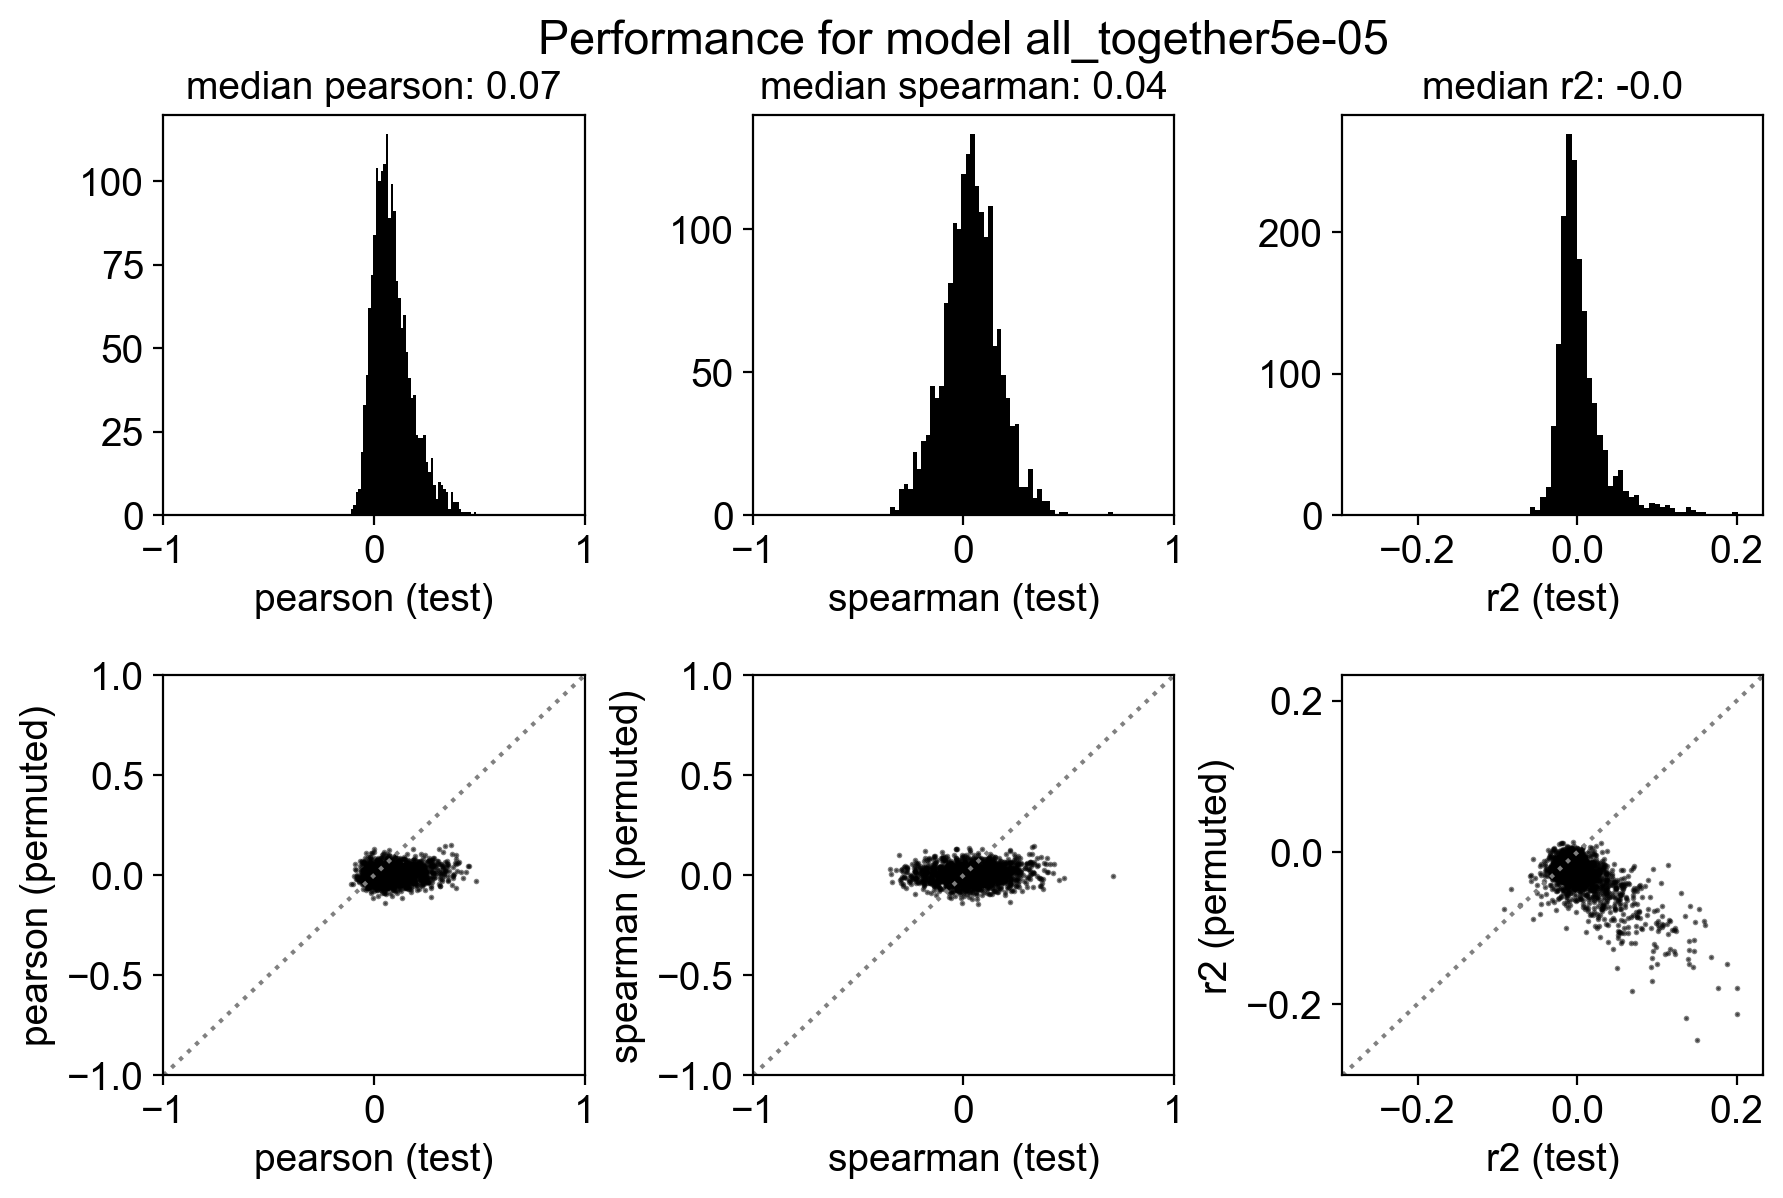

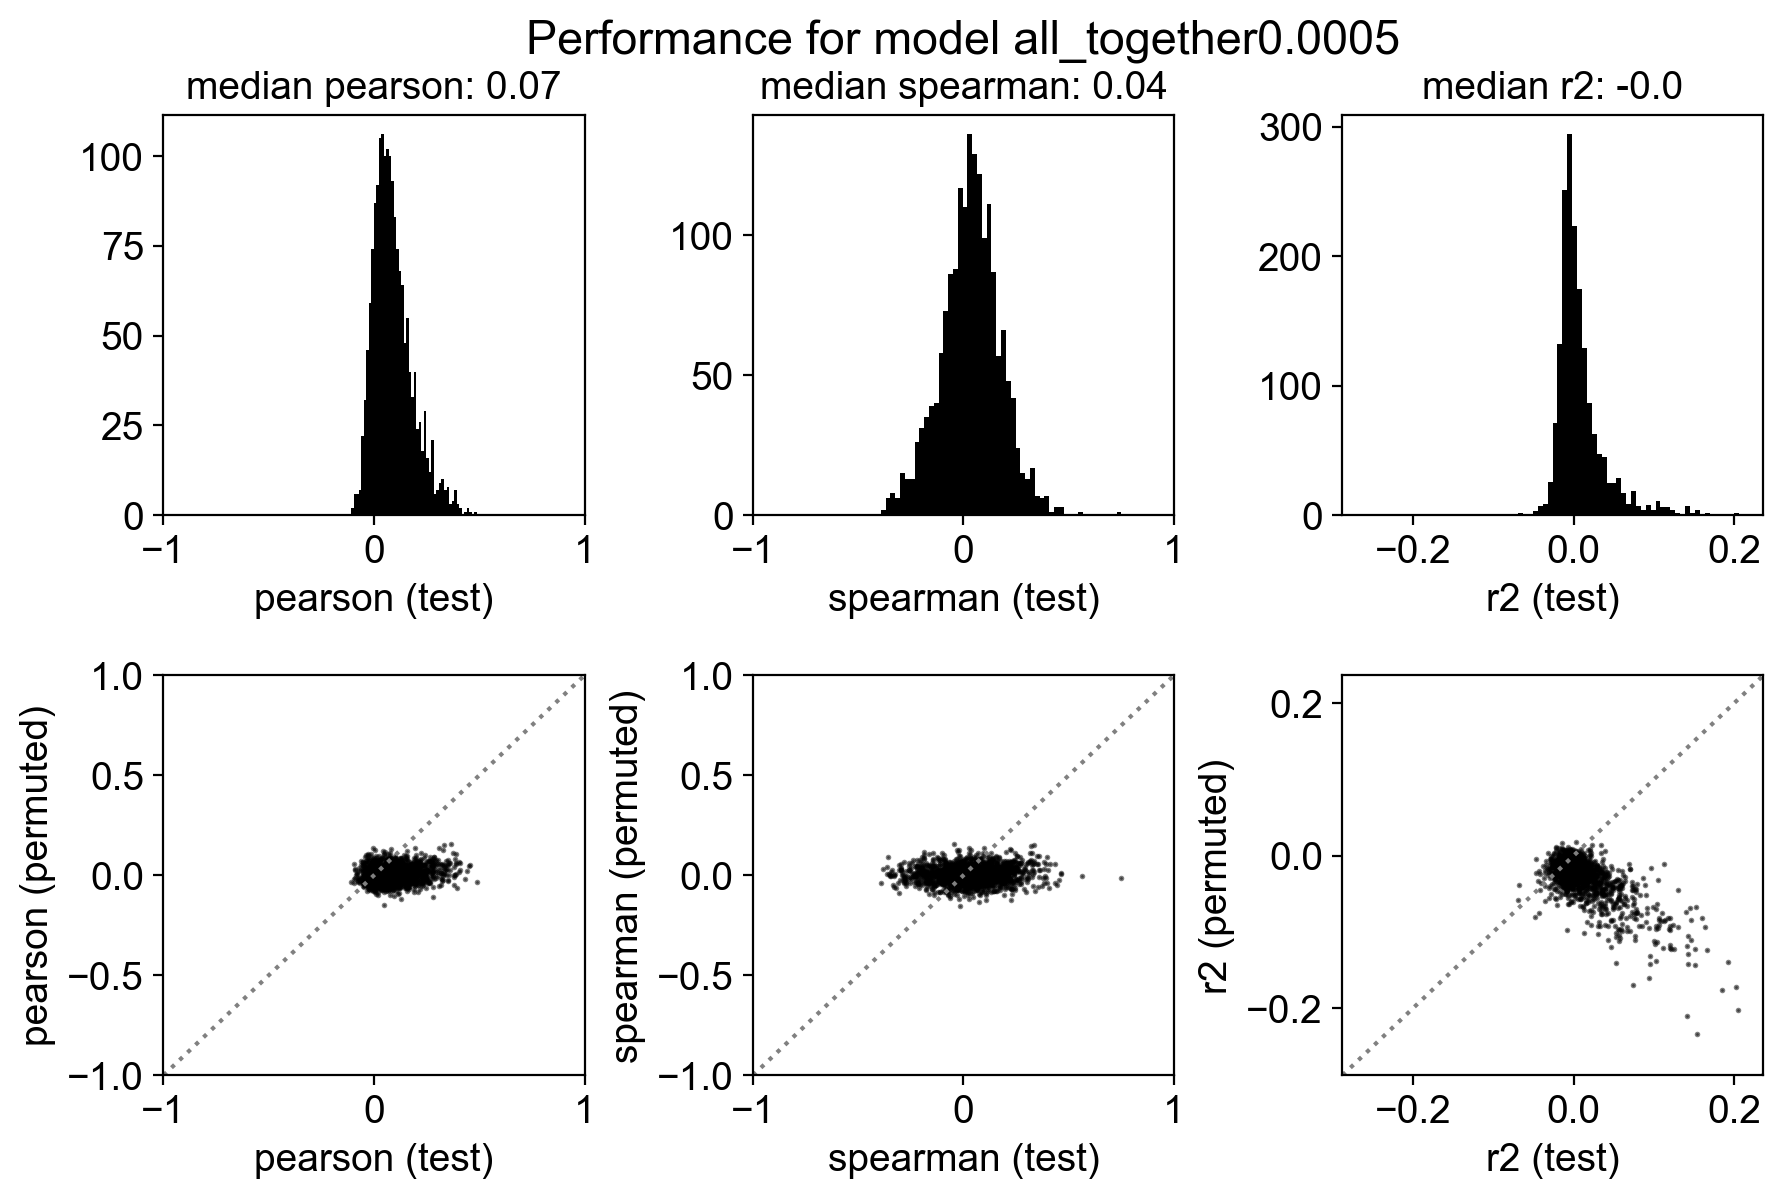

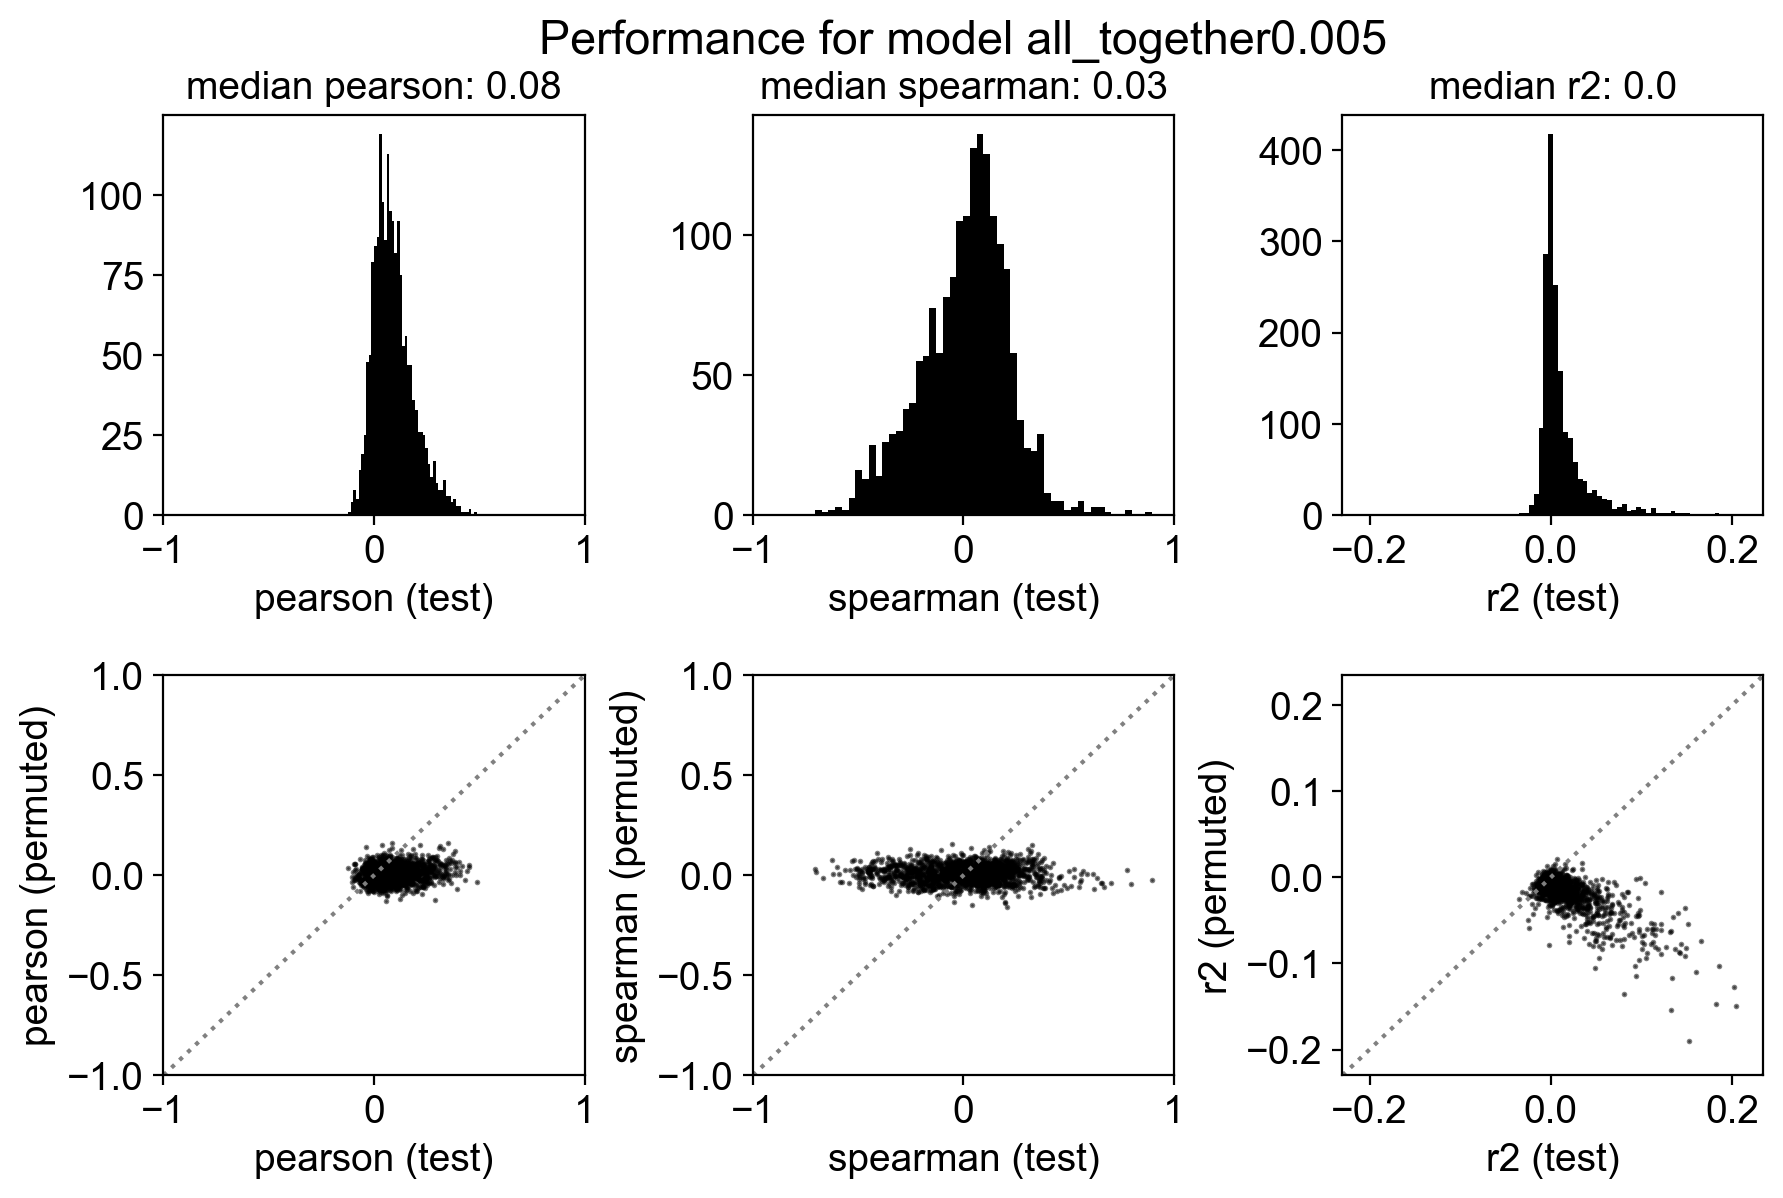

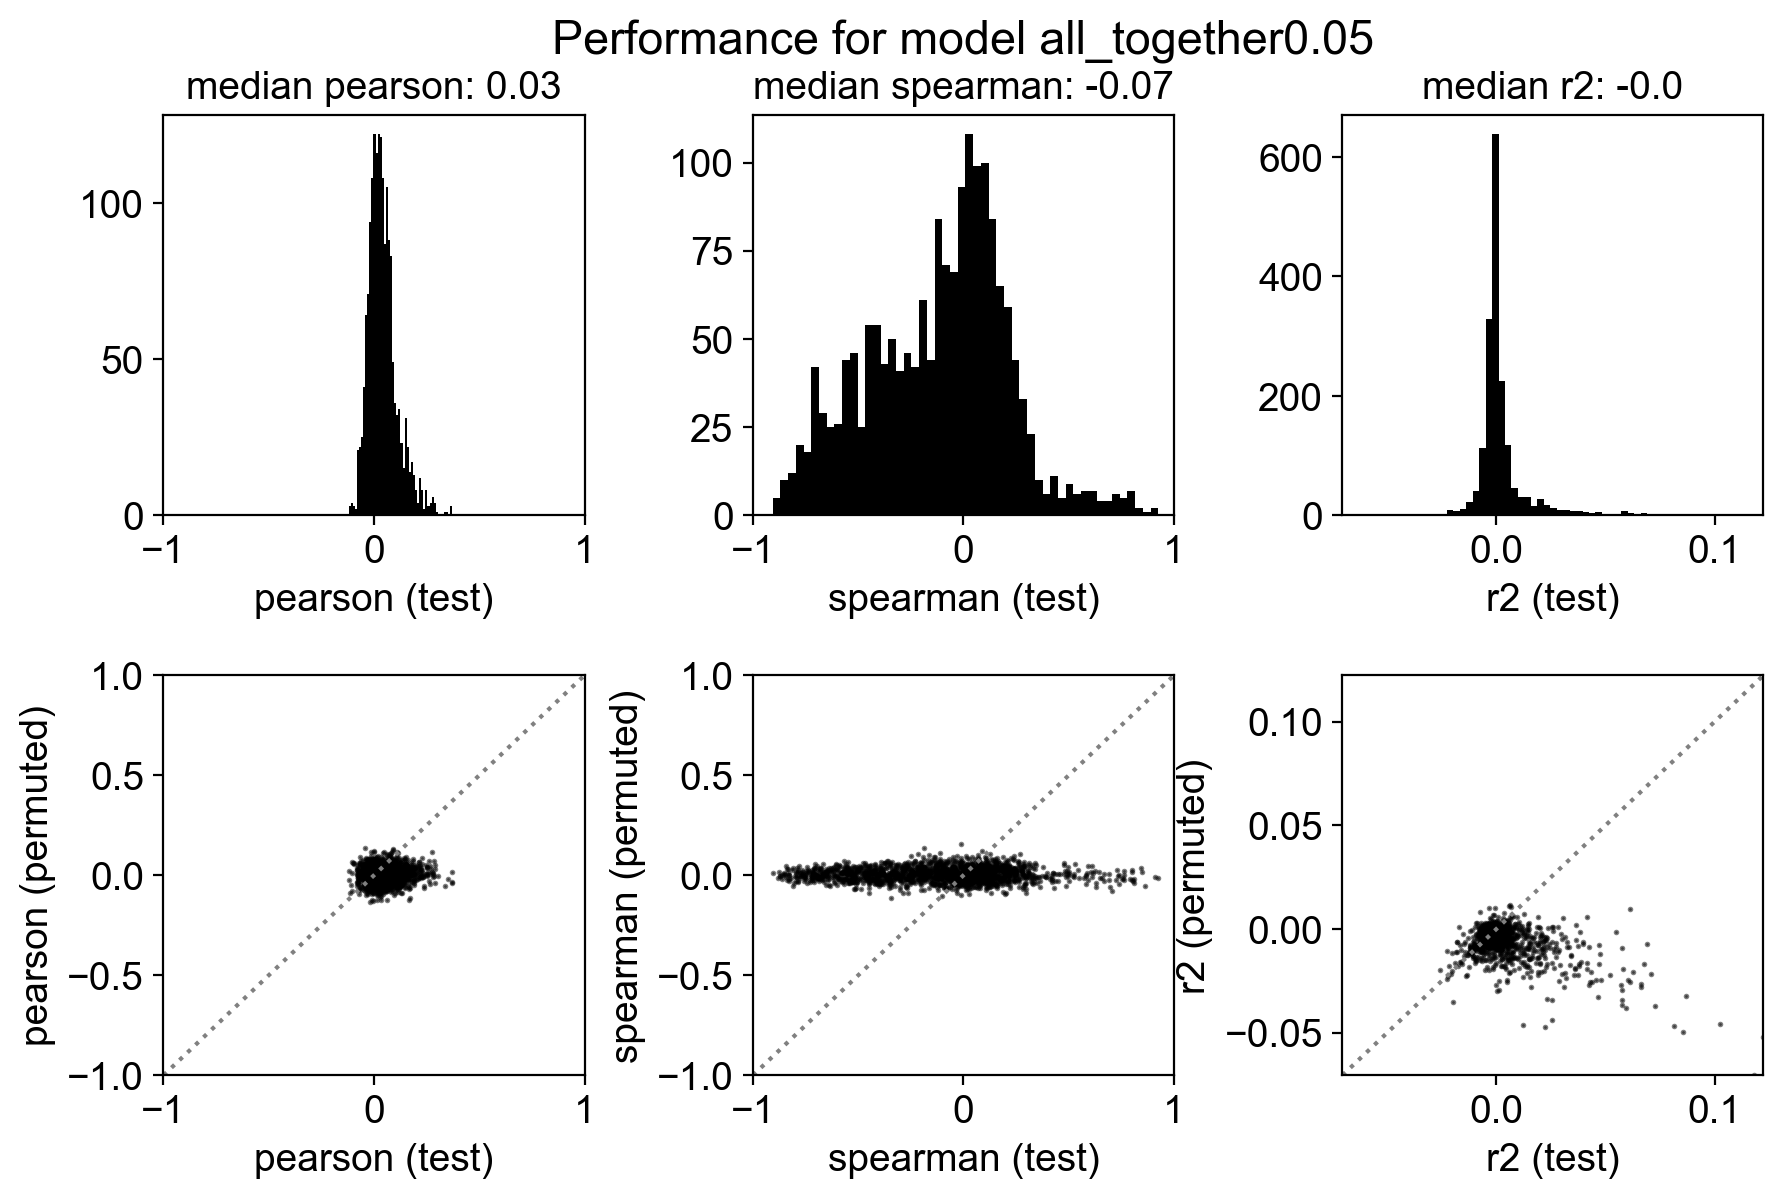

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model


for alpha in [
              0.00005,
              0.0005,
              0.005,
              0.05,
             ]:


    my_rng=np.random.RandomState(1234)
    reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

    modelname='all_together'+str(alpha)

    perturb.lm.train_lm(adata_small,
            lm=reg,
            include_expression=True,
            #y_obs=pcs,
            model_name=modelname,
            perturbations_list=['c.'+gene for gene in genes_perturbed],#gene_guides_w_combo,
            covariates_list=covariates,
            my_rng=my_rng,
            adjust=False,
             adjust_vars=[],
            copy_adata=False,
            keep_unassigned=False,
             control_names=['control'],
           use_raw=False)
    
    perturb.pl.plot_model_performance(adata_small,modelname)

In [15]:
adata_small.write(pref+'.guide_qc.lm_combos.h5ad')

... storing 'PS.all_together5e-05.train_valid_test' as categorical
... storing 'PS.all_together0.0005.train_valid_test' as categorical
... storing 'PS.all_together0.005.train_valid_test' as categorical
... storing 'PS.all_together0.05.train_valid_test' as categorical


In [50]:
#best model is 0.005
modelname='all_together0.005'

In [49]:
adata_small=sc.read(pref+'.guide_qc.lm_combos.h5ad')
adata_small

Only considering the two last: ['.lm_combos', '.h5ad'].
Only considering the two last: ['.lm_combos', '.h5ad'].


AnnData object with n_obs × n_vars = 6891 × 1761
    obs: 'n_genes', 'batch', 'SMARCE1_1', 'DPF2_4', 'BCL7C_2', 'ARID2_1', 'NTC7_IG1144056', 'PHF10_1', 'SMARCA2_4', 'BCL7B_1', 'SMARCB1_5', 'ARID1B_4', 'NTC6_IG1216445', 'NTC1_IG345439', 'PBRM1_3', 'GLTSCR1_1', 'BCL7A_3', 'GLTSCR1L_3', 'SMARCC1_7', 'ARID1A_3', 'SMARCC2_3', 'SMARCA4_4', 'SS18_2', 'SMARCD2_3', 'BRD7_2', 'SMARCD1_4', 'SS18L_1', 'BRD9_2', 'SMARCB1', 'BRD7', 'PBRM1', 'BCL7A', 'PHF10', 'ARID1A', 'SS18', 'cell', 'BCL7C', 'BCL7B', 'SMARCC1', 'GLTSCR1', 'SMARCC2', 'control', 'DPF2', 'SMARCE1', 'SMARCA4', 'BRD9', 'GLTSCR1L', 'SS18L', 'ARID2', 'SMARCD2', 'SMARCD1', 'SMARCA2', 'ARID1B', 'guide', 'guide.compact', 'gene', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '0', '1', '2', 'leiden', 'cell_state', 'c.GLTSCR1L', 'c.BCL7A', 'c.SMARCD2', 'c.GLTSCR1', 'c.SS18L', 'c.SMARCC2', 'c.PBRM1', 'c.SMARCB1', 'c.SMARCA2', 'c.PHF10', 'c.SMARCE1', 'c.DPF2', 'c.ARID1B', 'c.SS18', 'c.BRD7'

/Users/ursuo/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


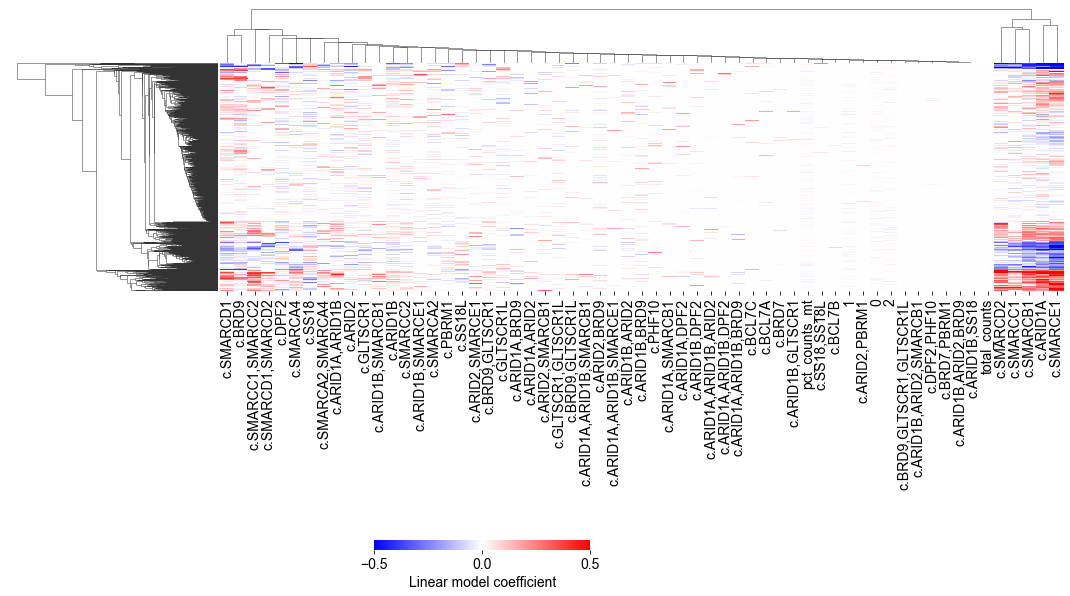

In [51]:
import seaborn as sns

coef=adata_small.uns['PS.'+modelname+'.coef']

x=0.5
sns.clustermap(coef,cmap='bwr',vmin=-x,vmax=x,
               #col_cluster=False,#row_cluster=False,
               figsize=(15,7),
               xticklabels=True,yticklabels=False,
               cbar_pos=(0.35, -0.1, 0.2, 0.02),
                 cbar_kws={'orientation':'horizontal',
                "label": "Linear model coefficient",
                'ticks':[-x,0,x]},
              )

In [19]:
import statsmodels   
from perturbseq.lm import _train_lm
from statsmodels.distributions.empirical_distribution import ECDF

    
def run_permuted_models(adata_here,
                        lm,
                       model_name='linear_model',
                       num_permutations=1,
                        rng=np.random.RandomState(1234),
                        adjust=False,
                       copy_adata=False):
    
    if copy_adata: adata_here = adata_here.copy()
        
    pref='PS.'+model_name
        
    if not adjust:
        try:
            xname='X'
            assert (pref+'.X' in adata_here.uns and pref+'.y' in adata_here.uns and pref+'.covariates' in adata_here.uns)
        except AssertionError:
            print('ERROR: '+'PS.'+model_name+'.X, y or covariates are missing. Run perturb.lm.train_lm() first')
            return
    else:
        try:
            xname='X_adjust'
            assert (pref+'.X_adjust' in adata_here.uns 
                and pref+'.y' in adata_here.uns 
                and pref+'.covariates' in adata_here.uns)
        except AssertionError:
                print('ERROR: '+'PS.'+model_name+'.X_adjust, y or covariates are missing. Run perturb.lm.train_lm() first')
                return
            
    
    #=====================
    #get permuted datasets
    #=====================
    print('== Permuting data')
    permuted_datasets={}
    for p in range(num_permutations):
        permuted_datasets[p]=pd.DataFrame(rng.permutation(np.array(adata_here.uns[pref+'.'+xname])),
                           index=adata_here.uns[pref+'.'+xname].index,
                           columns=adata_here.uns[pref+'.'+xname].columns)
    covariates=adata_here.uns[pref+'.covariates']
    
    
    X_df=adata_here.uns[pref+'.'+xname]
    X_cells=list(X_df.index)
    training=[cellidx for cellidx in range(X_df.shape[0]) if adata_here.obs[pref+'.train_valid_test'].loc[X_cells[cellidx]]=='train']
    
    for p in range(num_permutations):
        print('Running model on permuted data #'+str(p))
            
        X_plus_covariates=pd.concat([permuted_datasets[p],covariates],axis=1)
            
        #run the model
        perm_coef,perm_lm=_train_lm(X_plus_covariates,
                                   adata_here.uns[pref+'.y'],
                                   lm,
                                   training=training)
        
        if pref+'.perm'+str(p)+'.coef' in adata.uns:
            print('WARNING: Over-writing adata.uns["'+pref+'.perm'+str(p)+'.coef'+'"]')
        adata_here.uns[pref+'.perm'+str(p)+'.coef']=perm_coef
        if pref+'.perm'+str(p)+'.X' in adata.uns:
            print('WARNING: Over-writing adata.uns["'+pref+'.perm'+str(p)+'.X"]')
        adata_here.uns[pref+'.perm'+str(p)+'.X']=X_plus_covariates
            
    if copy_adata:
        return(adata_here)
    
    

In [52]:
alpha=0.005

my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

run_permuted_models(adata_small,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

== Permuting data
Running model on permuted data #0
Running model on permuted data #1
Running model on permuted data #2
Running model on permuted data #3
Running model on permuted data #4
Running model on permuted data #5
Running model on permuted data #6
Running model on permuted data #7
Running model on permuted data #8
Running model on permuted data #9


In [53]:
def label_coefs_with_covariates(adata_here,coef,perturbations_obs,
                               gmeans=None,gvars=None):
    
    genes_used=list(set(adata_here.var_names).intersection(set(coef.index)))
    
    #get all gene expressions and variances
    if gmeans == None:
        gmeans=pd.DataFrame({'gene':genes_used,
                             'mean':np.mean(adata_here.raw[:,genes_used].X.toarray(),axis=0)},
                           index=genes_used)
    if gvars == None:
        gvars=pd.DataFrame({'gene':genes_used,
                            'var':np.var(adata_here.raw[:,genes_used].X.toarray(),axis=0)},
                          index=genes_used)
        
    
    coef_df=pd.DataFrame(columns=['guide','gene','beta','gene_mean','gene_var','cells_per_guide'])
    for col in coef.columns:
        coef_df_here=pd.DataFrame({'guide':col,
                                  'gene':list(coef.index),
                                   'beta':coef.loc[:,col],
                                   'gene_mean':gmeans.loc[coef.index,'mean'],
                                   'gene_var':gvars.loc[coef.index,'var'],
                                   'cells_per_guide':np.sum(adata_here.obs[perturbations_obs]==col),
                                  })
        coef_df=pd.concat([coef_df,coef_df_here])
    return(coef_df)

def coef_FDR(adata_here,
             perturbations_obs,
            model_name='linear_model',
             num_permutations=1,
             bins=[3,3,23,1000],
            copy_adata=False):
    
    import statsmodels
    from statsmodels.sandbox.stats.multicomp import fdrcorrection0
    from statsmodels.stats.multitest import multipletests

    
    if copy_adata: adata_here = adata_here.copy()
    
    print('== Computing coefficient significance')
    
    genes_used=list(set(adata_here.var_names).intersection(set(adata_here.uns['PS.'+model_name+'.y'].columns)))
    perturbations=adata_here.uns['PS.'+model_name+'.X'].columns
    
    B_real=label_coefs_with_covariates(adata_here,
                                    adata_here.uns['PS.'+model_name+'.coef'],
                           perturbations_obs=perturbations_obs)
    B_real['data']='real'
    
    fdrs=[]
    
    
    if len(genes_used)>0:
        #annotate permuted coefficients
        B_shuff_list=[]
        for p in range(num_permutations):
            B_shuff_here=label_coefs_with_covariates(adata_here,
                                                             adata_here.uns['PS.'+model_name+'.perm'+str(p)+'.coef'],
                           perturbations_obs=perturbations_obs)
            B_shuff_list.append(B_shuff_here)
        
        B_perm=pd.concat(B_shuff_list)
        B_perm['data']='perm'
        B_full=pd.concat([B_real,B_perm])
        
        #bin coefficients
        for covariate in ['gene_mean','gene_var','cells_per_guide']:
            #TODO: not hardcode this
            num_bins=1 
            B_full['bin.'+covariate]=pd.cut(B_full[covariate],
                                           bins=num_bins,labels=range(num_bins),
                                          )
        #name the bins
        B_full['bin']=B_full['bin.gene_mean'].astype(str)+B_full['bin.gene_var'].astype(str)+B_full['bin.cells_per_guide'].astype(str)
            
        B_perm=B_full.loc[B_full['data']=='perm',:]
        B_real=B_full.loc[B_full['data']=='real',:]
        bins=list(B_full['bin'].value_counts().index)
        
        for b in bins:
            #make ecdf
            B_perm_betas=np.abs(B_perm.loc[B_perm['bin']==b,'beta'])
            from statsmodels.distributions.empirical_distribution import ECDF
            ecdf_here=ECDF(B_perm_betas)
            fdr_here=pd.DataFrame(B_real.loc[B_real['bin']==b,:])
            probs=1-ecdf_here(np.abs(fdr_here['beta']))
            beta_sign=np.sign(fdr_here['beta'])
            #set pseudocount as smallest nonzero fdr
            fdr_here['FDR']=probs
            fdrs.append(fdr_here)
        fdrs=pd.concat(fdrs)
        print('fdr',fdrs['FDR'])
        ps=np.min(np.array(fdrs['FDR'])[np.nonzero(np.array(fdrs['FDR']))])
        fdrs['signed.-log10FDR']=np.sign(fdrs['beta'])*(-np.log10(multipletests(fdrs['FDR']+ps,method='fdr_bh')[1]))
        #reshape back the FDRs into a matrix
        fdr_mat=fdrs.pivot(index='gene', columns='guide', values='signed.-log10FDR')
    
    if 'PS.'+model_name+'.coef_FDR' in adata_here.uns:
        print('WARNING: Over-writing adata.uns["'+'PS.'+model_name+'.coef_FDR"]')
    adata_here.uns['PS.'+model_name+'.coef_FDR']=fdr_mat
    
    if copy_adata:
        return(adata_here)
    
coef_FDR(adata_small,'gene',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])



== Computing coefficient significance
fdr SDCBP         0.188838
BTN3A1        0.188838
MAP2K1        0.188838
FBXL5         0.144402
FGD3          0.042184
                ...   
JAML          0.188838
AL022069.3    0.188838
H6PD          0.188838
ZYG11A        0.188838
BCL6          0.188838
Name: FDR, Length: 107421, dtype: float64


In [54]:
def compute_gene_interaction_profile_per_perturbation_pairs(coef_fdr,
                                                           fdr=0.05):
    
    result={}
    
    #hard-coding the options here
    interaction_types={'11-1':'buffering',
                       '-1-11':'buffering',
                       '10-1':'buffering',
                       '01-1':'buffering',
                       '-101':'buffering',
                       '0-11':'buffering',
                       
                       '111':'synergistic',
                       '-1-1-1':'synergistic',
                       '00-1':'synergistic',
                       '001':'synergistic',
                       '101':'synergistic',
                       '011':'synergistic',
                       '-10-1':'synergistic',
                       '0-1-1':'synergistic',
                       
                       '1-1-1':'dominant',
                       '-111':'dominant',
                       '1-11':'dominant',
                       '-11-1':'dominant',
                       
                       '100':'additive',
                       '010':'additive',
                       '-100':'additive',
                       '0-10':'additive',
                       '110':'additive',
                       '-1-10':'additive',
                       '1-10':'additive',
                       '-110':'additive',
                       
                       '000':'not significant',
                      
                      }
    #colors
    paircolors={'not significant':'lightgray',
           'additive':'gray',
            'dominant':'green',
            'synergistic':'orange',
            'buffering':'purple',
    }
    
    #TODO: sort so that interaction term is the last
    
    gene_class=pd.DataFrame({'y':list(coef_fdr.index),
                             'int_type':'not significant'},
                            index=list(coef_fdr.index))
    gene_profiles=(coef_fdr.abs()>=(-np.log10(fdr)))*1*np.sign(coef_fdr).astype(int)
    gene_profiles=gene_profiles.astype(str).apply(''.join, axis=1)
    gene_class['int_type']=[interaction_types[k] for k in gene_profiles]
    gene_profiles_formal=[]
    import re
    for i in range(len(gene_profiles)):
        gene_profile_formal=re.sub('1','+',re.sub('-1','-',gene_profiles[i]))
        gene_profiles_formal.append(gene_profile_formal)
    gene_class['coef_pattern']=gene_profiles_formal
    #also make a vector with the colors, to have ready
    gene_class['int_type_colors']=pd.DataFrame({'color':[paircolors[k] for k in gene_class['int_type']]},
                        index=gene_class['int_type'].index)
    
    result['int_type']=gene_class.loc[:,['int_type','coef_pattern','int_type_colors']]
                                                                                                  
    #compute the percent genes in each category
    result['percent_int_types']={}
    for v in ['int_type','coef_pattern']:
        interaction_class_counts=gene_class[v].value_counts()
        percent_class=pd.DataFrame({'percent_'+v:np.round(100*np.array(interaction_class_counts)/interaction_class_counts.sum(),2),
                                   },
                                   index=interaction_class_counts.index)
        result['percent_int_types'][v]=percent_class 
        
    return(result)
    

def gene_interaction_profile_per_perturbation_pairs(adata_here,
                                                    perturbations,
                                                   model_name='linear_model',
                                                    fdr=0.05,
                                                    copy=False,
                                                   ):
    
    if copy: adata_here = adata_here.copy()
        
        
    #check that the perturbations are in the dataset
    try:
        fdrname='PS.'+model_name+'.coef_FDR'
        assert fdrname in adata_here.uns
    except AssertionError:
        print('ERROR: "'+fdrname+'" not in adata.uns. Please run perturb.lm.coef_FDR() first')
        return
    
    try:
        assert len(perturbations)==3
        for perturbation in perturbations:
            assert perturbation in adata_here.uns[fdrname].columns
    except AssertionError:
        print('ERROR: :'+perturbation+'" not in adata.uns["'+fdrname+'"].')
        return
        
    #compute the items
    coef_fdr=adata_here.uns[fdrname].loc[:,perturbations]
    gene_profile_data=compute_gene_interaction_profile_per_perturbation_pairs(coef_fdr,
                                                                             fdr)
    
    #save results to adata
    adata_here.uns['PS.'+model_name+'.int_type'+'.'+'|'.join(perturbations)]=gene_profile_data['int_type']
    #compute the percent genes in each category
    for v in gene_profile_data['percent_int_types'].keys():
        adata_here.uns['PS.'+model_name+'.int_type'+'.'+v+'.pct.'+'|'.join(perturbations)]=gene_profile_data['percent_int_types'][v]    
    
    if copy:
        return(adata_here)




In [55]:

def plot_interaction_term_data(adata_small,modelname,g1,g2):
    gene_guides_w_combo=['c.'+g1,'c.'+g2,'c.'+g1+','+g2]

    gene_interaction_profile_per_perturbation_pairs(adata_small,
                                                   model_name=modelname,
                                                    perturbations=gene_guides_w_combo,
                                                fdr=0.01,
                                                   )
    gene_guides_here=gene_guides_w_combo
    adata2=adata_small
    
    #get each type of gene
    #cluster within those genes
    #combine at the end

    from scipy.cluster import hierarchy
    from scipy.cluster.hierarchy import dendrogram, linkage

    fdr=0.01

    gs=gene_guides_here
    coef=adata2.uns['PS.'+modelname+'.coef'].loc[:,gs]
    fulldata=pd.DataFrame(columns=gs)
    int_df=adata2.uns['PS.'+modelname+'.int_type.'+'|'.join(gene_guides_here)]
    #int_df=int_df.loc[de_genes,:]
    print(int_df.shape)


    inttypes=['000',
             '-100',
              '0-10',
              '-1-10',

              '100',
              '010',
              '110',

              '1-10',
              '-110',

              #syn
              '-10-1',
              '0-1-1',
              '-1-1-1',

              '101',
              '011',
              '111',

              '00-1', 
              '001',

              #dominants
              '1-1-1', 
              '-111', '1-11', '-11-1',

              #buffers
              '11-1', '-1-11', '10-1', '01-1', '-101', '0-11',
             ]




    colors=[]
    current_color='lightgray'

    cutoffs=[]
    gene2pro={}
    import re
    for k in inttypes:
        inttype=re.sub('1','+',re.sub('-1','-',k))
        if inttype=='000':
            continue
        genes_here=list(int_df.loc[int_df['coef_pattern']==inttype,:].index)
        print(inttype,len(genes_here))

        coef_data=coef.loc[genes_here,gs]
        if len(genes_here)==0:
            continue

        gene2pro[inttype]=genes_here
        if len(genes_here)>=2:
            #cluster coef data here
            var_Z = hierarchy.linkage(coef_data,
                                 optimal_ordering=True,
                                  #metric='cityblock',
                                         method='median')
            dn = dendrogram(var_Z,no_plot=True)
            coef_data=coef_data.iloc[dn['leaves'],:]
        if current_color=='lightgray':
            current_color='black'
        elif current_color=='black':
            current_color='lightgray'
        for i in range(len(genes_here)):
            colors.append(current_color)

        fulldata=pd.concat([fulldata,coef_data])
        cutoffs.append(fulldata.shape[0])
    color_df=pd.DataFrame({'color':colors},
                         index=fulldata.index)
    
    %matplotlib inline
    import seaborn as sns
    x=1

    from matplotlib.patches import Rectangle
    color_df['interaction_type']=adata2.uns['PS.'+modelname+'.int_type.'+'|'.join(gene_guides_here)]['int_type_colors'].loc[fulldata.index]

    fulldata['sum']=fulldata.iloc[:,:3].sum(axis=1)
    g=sns.clustermap(fulldata,
                   col_cluster=False,
                   row_cluster=False,
                   vmin=-x,vmax=x,
                   cmap='bwr',xticklabels=True,
                     yticklabels=False,
                   #row_linkage=var_Z,
                   row_colors=color_df['interaction_type'],
                     cbar_pos=(0.5, 0.99, 0.25, 0.02),
                     cbar_kws={'orientation':'horizontal',
                    "label": "Linear model coefficient",
                    'ticks':[-x,x]},
                   figsize=(3,6),
                  )
    ax = g.ax_heatmap

    for i in range(len(cutoffs)):
        ax.add_patch(Rectangle((0,cutoffs[i]), 
                                   10, 0.5, 
                                   edgecolor='black', fill=False, lw=0.5))
    plt.savefig(FIGS+'combo.regMat.interaction'+modelname+g1+'.'+g2+'.heatmap.pdf',transparent=True,bbox_inches='tight')
    plt.savefig(FIGS+'combo.regMat.interaction'+modelname+g1+'.'+g2+'.heatmap.png',transparent=True,bbox_inches='tight')

    return(fulldata,color_df['interaction_type'],int_df['coef_pattern'])



In [56]:
def programs2go(program2gene_dict,organism="hsapiens"):
    
    gotable=pd.DataFrame(columns=['name','p_value','program'])
    
    for program in program2gene_dict:
        print(program)
        genes=program2gene_dict[program]
        go_res=sc.queries.enrich(genes, org=organism)
        #go_res=go_res.loc[go_res['significant'],:]
        #print(go_res.head())
        gotable_current=go_res.loc[go_res['source']=='GO:BP',['name','p_value']]
        if gotable_current.shape[0]==0:
            continue
        #correct p-value for multiple testing
        from statsmodels.stats.multitest import multipletests
        gotable_current['p_value2']=multipletests(gotable_current['p_value'],method='fdr_bh')[1]
        gotable_current['program']='Pro: '+str(program)
        gotable=pd.concat([gotable,gotable_current],axis=0)
    go_table_result=gotable.pivot(index='name',columns='program')[['p_value2']]
    go_table_result=go_table_result.fillna(1)
    go_table_result=-np.log10(go_table_result)
    
    #go through each program and print me the sig go terms
    for program in go_table_result.columns:
        keep=go_table_result.loc[go_table_result[program]>1.0,:]
        keep=keep.sort_values(by=program,ascending=False)[program]
        print(program)
        print(keep)
        print('======')
    return(go_table_result)

def go_analysis(gene_interaction_term):

    cat2gene={}
    for cat in set(gene_interaction_term):
        cat2gene[cat]=list(gene_interaction_term.index[gene_interaction_term==cat])
        print(cat,len(cat2gene[cat]),'sig here',gene_interaction_term.shape[0],
              'fraction of sig',1.0*len(cat2gene[cat])/gene_interaction_term.shape[0],
              'fraction of vargenes',1.0*len(cat2gene[cat])/adata_small.n_vars,
             )
    gos=programs2go(cat2gene)
    return(gos)

In [57]:
adata_small

AnnData object with n_obs × n_vars = 6891 × 1761
    obs: 'n_genes', 'batch', 'SMARCE1_1', 'DPF2_4', 'BCL7C_2', 'ARID2_1', 'NTC7_IG1144056', 'PHF10_1', 'SMARCA2_4', 'BCL7B_1', 'SMARCB1_5', 'ARID1B_4', 'NTC6_IG1216445', 'NTC1_IG345439', 'PBRM1_3', 'GLTSCR1_1', 'BCL7A_3', 'GLTSCR1L_3', 'SMARCC1_7', 'ARID1A_3', 'SMARCC2_3', 'SMARCA4_4', 'SS18_2', 'SMARCD2_3', 'BRD7_2', 'SMARCD1_4', 'SS18L_1', 'BRD9_2', 'SMARCB1', 'BRD7', 'PBRM1', 'BCL7A', 'PHF10', 'ARID1A', 'SS18', 'cell', 'BCL7C', 'BCL7B', 'SMARCC1', 'GLTSCR1', 'SMARCC2', 'control', 'DPF2', 'SMARCE1', 'SMARCA4', 'BRD9', 'GLTSCR1L', 'SS18L', 'ARID2', 'SMARCD2', 'SMARCD1', 'SMARCA2', 'ARID1B', 'guide', 'guide.compact', 'gene', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '0', '1', '2', 'leiden', 'cell_state', 'c.GLTSCR1L', 'c.BCL7A', 'c.SMARCD2', 'c.GLTSCR1', 'c.SS18L', 'c.SMARCC2', 'c.PBRM1', 'c.SMARCB1', 'c.SMARCA2', 'c.PHF10', 'c.SMARCE1', 'c.DPF2', 'c.ARID1B', 'c.SS18', 'c.BRD7'

In [58]:
adata_small.write(pref+'.guide_qc.lm_combos.h5ad')

In [27]:
adata_small=sc.read(pref+'.guide_qc.lm_combos.h5ad')
adata_small

Only considering the two last: ['.lm_combos', '.h5ad'].
Only considering the two last: ['.lm_combos', '.h5ad'].


AnnData object with n_obs × n_vars = 6891 × 1761
    obs: 'n_genes', 'batch', 'SMARCE1_1', 'DPF2_4', 'BCL7C_2', 'ARID2_1', 'NTC7_IG1144056', 'PHF10_1', 'SMARCA2_4', 'BCL7B_1', 'SMARCB1_5', 'ARID1B_4', 'NTC6_IG1216445', 'NTC1_IG345439', 'PBRM1_3', 'GLTSCR1_1', 'BCL7A_3', 'GLTSCR1L_3', 'SMARCC1_7', 'ARID1A_3', 'SMARCC2_3', 'SMARCA4_4', 'SS18_2', 'SMARCD2_3', 'BRD7_2', 'SMARCD1_4', 'SS18L_1', 'BRD9_2', 'SMARCB1', 'BRD7', 'PBRM1', 'BCL7A', 'PHF10', 'ARID1A', 'SS18', 'cell', 'BCL7C', 'BCL7B', 'SMARCC1', 'GLTSCR1', 'SMARCC2', 'control', 'DPF2', 'SMARCE1', 'SMARCA4', 'BRD9', 'GLTSCR1L', 'SS18L', 'ARID2', 'SMARCD2', 'SMARCD1', 'SMARCA2', 'ARID1B', 'guide', 'guide.compact', 'gene', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '0', '1', '2', 'leiden', 'cell_state', 'c.GLTSCR1L', 'c.BCL7A', 'c.SMARCD2', 'c.GLTSCR1', 'c.SS18L', 'c.SMARCC2', 'c.PBRM1', 'c.SMARCB1', 'c.SMARCA2', 'c.PHF10', 'c.SMARCE1', 'c.DPF2', 'c.ARID1B', 'c.SS18', 'c.BRD7'

(1761, 3)
-00 125
0-0 0
--0 1
+00 224
0+0 0
++0 1
+-0 0
-+0 0
-0- 1
0-- 0
--- 0
+0+ 5
0++ 0
+++ 0
00- 1
00+ 12
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
orange 19 sig here 370 fraction of sig 0.051351351351351354 fraction of vargenes 0.010789324247586598
gray 351 sig here 370 fraction of sig 0.9486486486486486 fraction of vargenes 0.19931856899488926
orange
gray
('p_value2', 'Pro: gray')
name
immune system process                                                        17.239669
cell activation                                                              13.480324
leukocyte activation                                                         12.388262
response to stimulus                                                         11.016319
biological process involved in interspecies interaction between organisms    10.744367
                                                                               ...    
response to lipid                                               

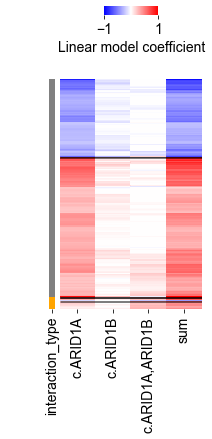

In [59]:
g1='ARID1A'
g2='ARID1B'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)

def print_terms(gos,cat):

    print(cat)
    if 'Pro: '+cat not in gos['p_value2']:
        print(cat,'not found')
    else:
        terms=gos['p_value2']['Pro: '+cat]
        terms=terms.sort_values(ascending=False)
        thresh=1
        for i in range(terms.shape[0]):
            if terms[i]>thresh:
                print(terms.index[i],np.round(terms.iloc[i],2))
    print('=====')
            


In [61]:
gos['p_value2']

program,Pro: +00,Pro: -00,Pro: 00+,Pro: 000
name,,,,
'de novo' posttranslational protein folding,-0.000000,3.510597,-0.0,-0.000000
'de novo' protein folding,-0.000000,3.302968,-0.0,-0.000000
B cell activation,2.466082,-0.000000,-0.0,2.542922
B cell differentiation,-0.000000,-0.000000,-0.0,2.732039
B cell proliferation,1.810643,-0.000000,-0.0,-0.000000
...,...,...,...,...
viral genome replication,-0.000000,-0.000000,-0.0,1.522915
viral life cycle,-0.000000,-0.000000,-0.0,2.941961
viral process,-0.000000,-0.000000,-0.0,2.057244


In [64]:
import re
print(gos['p_value2'].columns)
for cat in gos['p_value2'].columns:
    cat_here=re.sub('Pro: ','',cat)
    if cat_here=='000':
        continue
    print_terms(gos,cat_here)

Index(['Pro: +00', 'Pro: -00', 'Pro: 00+', 'Pro: 000'], dtype='object', name='program')
+00
immune system process 19.2
cell activation 16.22
leukocyte activation 15.61
immune response 12.47
defense response 11.57
regulation of immune system process 11.5
response to biotic stimulus 10.93
biological process involved in interspecies interaction between organisms 10.42
response to external biotic stimulus 10.25
regulation of cell activation 10.25
lymphocyte activation 10.25
response to other organism 10.25
T cell activation 10.25
immune system development 9.4
leukocyte cell-cell adhesion 9.12
response to stimulus 8.83
hematopoietic or lymphoid organ development 8.19
response to external stimulus 8.13
hemopoiesis 8.1
regulation of leukocyte activation 8.1
anatomical structure development 7.46
immune effector process 7.46
regulation of cell adhesion 6.94
cell-cell adhesion 6.84
regulation of cell-cell adhesion 6.76
developmental process 6.74
regulation of leukocyte cell-cell adhesion 6.72
po

(1761, 3)
-00 3
0-0 27
--0 0
+00 4
0+0 17
++0 0
+-0 0
-+0 0
-0- 0
0-- 1
--- 0
+0+ 0
0++ 1
+++ 0
00- 4
00+ 21
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
orange 27 sig here 78 fraction of sig 0.34615384615384615 fraction of vargenes 0.015332197614991482
gray 51 sig here 78 fraction of sig 0.6538461538461539 fraction of vargenes 0.028960817717206135
orange
gray
('p_value2', 'Pro: gray')
name
stress response to metal ion                 7.135199
stress response to copper ion                5.877854
detoxification of copper ion                 5.877854
detoxification of inorganic compound         5.665421
response to metal ion                        5.645225
cellular response to metal ion               5.598245
response to inorganic substance              5.130901
cellular response to inorganic substance     5.130901
cellular response to zinc ion                5.130901
response to zinc ion                         5.119833
cellular response to copper ion              4.9341

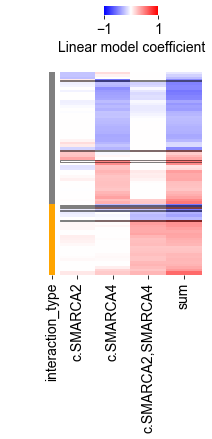

In [29]:
g1='SMARCA2'
g2='SMARCA4'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)
import re
for cat in gos['p_value2'].columns:
    print_terms(gos,re.sub('Pro: ','',cat))

(1761, 3)
-00 45
0-0 0
--0 1
+00 67
0+0 1
++0 0
+-0 0
-+0 0
-0- 6
0-- 0
--- 0
+0+ 17
0++ 0
+++ 0
00- 21
00+ 80
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
orange 124 sig here 238 fraction of sig 0.5210084033613446 fraction of vargenes 0.0704145371947757
gray 114 sig here 238 fraction of sig 0.4789915966386555 fraction of vargenes 0.06473594548551959
orange
gray
('p_value2', 'Pro: gray')
name
regulation of immune system process                                                4.162976
immune system process                                                              3.768069
developmental process                                                              2.930597
positive regulation of immune system process                                       2.640217
multicellular organismal process                                                   2.563252
system development                                                                 2.496786
multicellular organism development   

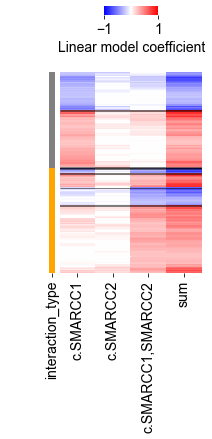

In [66]:
g1='SMARCC1'
g2='SMARCC2'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)
import re
for cat in gos['p_value2'].columns:
    if '000' in cat:
        continue
    print_terms(gos,re.sub('Pro: ','',cat))

In [31]:
def print_terms(gos,cat):

    print(cat)
    if 'Pro: '+cat not in gos['p_value2']:
        print(cat,'not found')
    else:
        terms=gos['p_value2']['Pro: '+cat]
        terms=terms.sort_values(ascending=False)
        thresh=1
        for i in range(terms.shape[0]):
            if terms[i]>thresh:
                print(terms.index[i],np.round(terms.iloc[i],2))
    print('=====')
            
print_terms(gos,'+0+')
print_terms(gos,'-0-')
print_terms(gos,'0++')
print_terms(gos,'0--')
print_terms(gos,'00+')
print_terms(gos,'00-')

+0+
leukocyte cell-cell adhesion 1.93
immune system process 1.43
=====
-0-
-0- not found
=====
0++
0++ not found
=====
0--
0-- not found
=====
00+
negative regulation of immune system process 3.13
negative regulation of leukocyte activation 2.23
negative regulation of cell activation 2.04
regulation of leukocyte activation 1.99
response to stimulus 1.99
regulation of cell activation 1.8
immune system process 1.8
negative regulation of immune response 1.8
leukocyte activation 1.75
dATP catabolic process 1.35
positive regulation of cell migration 1.35
negative regulation of mast cell activation 1.35
defense response 1.35
immune response 1.35
alpha-beta T cell activation 1.35
cell activation 1.34
positive regulation of cell motility 1.34
negative regulation of cellular process 1.32
positive regulation of cellular component movement 1.31
positive regulation of locomotion 1.31
regulation of alpha-beta T cell activation 1.3
negative regulation of response to stimulus 1.3
=====
00-
'de novo' 

(1761, 3)
-00 17
0-0 43
--0 11
+00 53
0+0 117
++0 25
+-0 2
-+0 0
-0- 4
0-- 3
--- 3
+0+ 4
0++ 13
+++ 7
00- 10
00+ 28
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 1
0+- 0
-0+ 0
0-+ 0
purple 1 sig here 341 fraction of sig 0.002932551319648094 fraction of vargenes 0.0005678591709256105
orange 72 sig here 341 fraction of sig 0.21114369501466276 fraction of vargenes 0.04088586030664395
gray 268 sig here 341 fraction of sig 0.7859237536656891 fraction of vargenes 0.1521862578080636
purple
orange
gray
('p_value2', 'Pro: gray')
name
immune system process                                        11.510442
response to stress                                           10.733045
defense response                                              8.923928
cell activation                                               8.823187
response to organic substance                                 8.339384
                                                               ...    
negative regulation of cellular protein metabolic

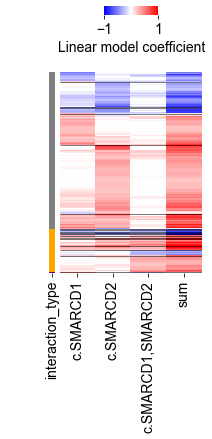

In [32]:
g1='SMARCD1'
g2='SMARCD2'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)


In [33]:
print_terms(gos,'+0+')
print_terms(gos,'-0-')
print_terms(gos,'0++')
print_terms(gos,'0--')
print_terms(gos,'00+')
print_terms(gos,'00-')
print_terms(gos,'---')
print_terms(gos,'+++')

+0+
+0+ not found
=====
-0-
-0- not found
=====
0++
0++ not found
=====
0--
0-- not found
=====
00+
00+ not found
=====
00-
regulation of DNA metabolic process 1.34
positive regulation by host of viral genome replication 1.34
viral genome replication 1.34
positive regulation by host of viral process 1.34
organelle organization 1.34
modulation by host of viral genome replication 1.34
DNA metabolic process 1.34
=====
---
'de novo' protein folding 1.97
activation of cysteine-type endopeptidase activity involved in apoptotic process 1.63
=====
+++
+++ not found
=====


(1761, 3)
-00 4
0-0 0
--0 0
+00 9
0+0 0
++0 1
+-0 0
-+0 0
-0- 0
0-- 0
--- 0
+0+ 0
0++ 0
+++ 0
00- 0
00+ 0
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
gray 14 sig here 14 fraction of sig 1.0 fraction of vargenes 0.007950028392958546
gray
('p_value2', 'Pro: gray')
name
regulation of cell adhesion                          1.930303
regulation of cell-cell adhesion                     1.930303
positive regulation of lipid biosynthetic process    1.559211
positive regulation of cell-cell adhesion            1.543813
Name: (p_value2, Pro: gray), dtype: float64
-00 4 sig here 1761 fraction of sig 0.002271436683702442 fraction of vargenes 0.002271436683702442
+00 9 sig here 1761 fraction of sig 0.005110732538330494 fraction of vargenes 0.005110732538330494
++0 1 sig here 1761 fraction of sig 0.0005678591709256105 fraction of vargenes 0.0005678591709256105
000 1747 sig here 1761 fraction of sig 0.9920499716070414 fraction of vargenes 0.9920499716070414
-00
+00
++0
000
('p_value2'

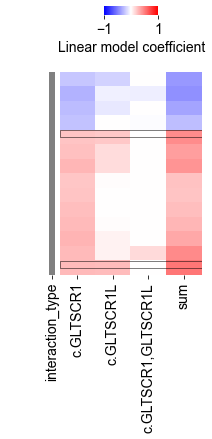

In [67]:
g1='GLTSCR1'
g2='GLTSCR1L'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)
import re
for cat in gos['p_value2'].columns:
    if '000' in cat:
        continue
    print_terms(gos,re.sub('Pro: ','',cat))

(1761, 3)
-00 7
0-0 16
--0 4
+00 1
0+0 75
++0 0
+-0 0
-+0 0
-0- 0
0-- 0
--- 0
+0+ 0
0++ 0
+++ 0
00- 0
00+ 1
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
orange 1 sig here 104 fraction of sig 0.009615384615384616 fraction of vargenes 0.0005678591709256105
gray 103 sig here 104 fraction of sig 0.9903846153846154 fraction of vargenes 0.05848949460533787
orange
gray
('p_value2', 'Pro: gray')
name
immune system process                                  6.616371
immune effector process                                6.075273
detoxification                                         5.768143
regulation of immune system process                    5.472278
response to stress                                     4.762016
                                                         ...   
cation homeostasis                                     1.313863
positive regulation of smooth muscle cell migration    1.311859
multicellular organismal process                       1.310660
regulation of

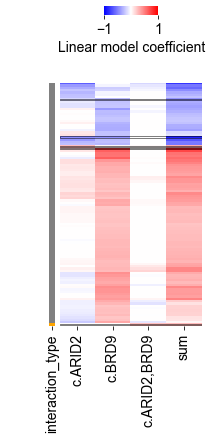

In [36]:
g1='ARID2'
g2='BRD9'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)
print_terms(gos,'+0+')
print_terms(gos,'-0-')
print_terms(gos,'0++')
print_terms(gos,'0--')
print_terms(gos,'00+')
print_terms(gos,'00-')
print_terms(gos,'---')
print_terms(gos,'+++')

(1761, 3)
-00 22
0-0 2
--0 0
+00 15
0+0 4
++0 1
+-0 0
-+0 0
-0- 0
0-- 0
--- 0
+0+ 0
0++ 0
+++ 0
00- 0
00+ 0
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
gray 44 sig here 44 fraction of sig 1.0 fraction of vargenes 0.02498580352072686
gray
('p_value2', 'Pro: gray')
name
detoxification of copper ion                                 8.073538
stress response to copper ion                                8.073538
detoxification of inorganic compound                         7.824866
stress response to metal ion                                 7.585862
cellular response to zinc ion                                6.950363
                                                               ...   
B cell activation involved in immune response                1.405757
mature B cell differentiation involved in immune response    1.366226
phagocytosis                                                 1.363843
signal transduction                                          1.319078
immune effector

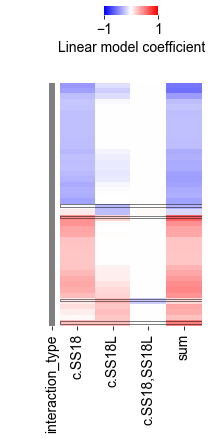

In [37]:
g1='SS18'
g2='SS18L'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)
print_terms(gos,'+0+')
print_terms(gos,'-0-')
print_terms(gos,'0++')
print_terms(gos,'0--')
print_terms(gos,'00+')
print_terms(gos,'00-')
print_terms(gos,'---')
print_terms(gos,'+++')

(1761, 3)
-00 12
0-0 0
--0 0
+00 27
0+0 1
++0 0
+-0 0
-+0 0
-0- 0
0-- 0
--- 0
+0+ 0
0++ 0
+++ 0
00- 0
00+ 0
+-- 0
-++ 0
+-+ 0
-+- 0
++- 0
--+ 0
+0- 0
0+- 0
-0+ 0
0-+ 0
gray 40 sig here 40 fraction of sig 1.0 fraction of vargenes 0.022714366837024418
gray


ValueError: zero-size array to reduction operation maximum which has no identity

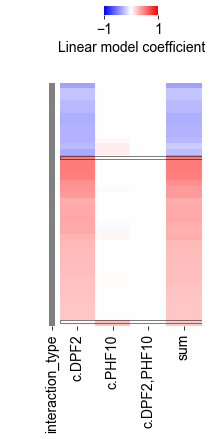

In [38]:
g1='DPF2'
g2='PHF10'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_small,modelname,g1,g2)
gos=go_analysis(gene_interaction_term)
gos=go_analysis(coef_pattern)
print_terms(gos,'+0+')
print_terms(gos,'-0-')
print_terms(gos,'0++')
print_terms(gos,'0--')
print_terms(gos,'00+')
print_terms(gos,'00-')
print_terms(gos,'---')
print_terms(gos,'+++')

In [39]:
gos=go_analysis(coef_pattern)
print_terms(gos,'+0+')
print_terms(gos,'-0-')
print_terms(gos,'0++')
print_terms(gos,'0--')
print_terms(gos,'00+')
print_terms(gos,'00-')
print_terms(gos,'---')
print_terms(gos,'+++')

-00 12 sig here 1761 fraction of sig 0.0068143100511073255 fraction of vargenes 0.0068143100511073255
+00 27 sig here 1761 fraction of sig 0.015332197614991482 fraction of vargenes 0.015332197614991482
0+0 1 sig here 1761 fraction of sig 0.0005678591709256105 fraction of vargenes 0.0005678591709256105
000 1721 sig here 1761 fraction of sig 0.9772856331629756 fraction of vargenes 0.9772856331629756
-00
+00
0+0
000
('p_value2', 'Pro: 000')
name
response to stimulus                             56.348440
response to stress                               52.048983
positive regulation of biological process        50.464559
cellular response to stimulus                    49.958530
regulation of cellular process                   49.355525
                                                   ...    
centromere complex assembly                       1.303640
response to ATP                                   1.303640
follicular B cell differentiation                 1.302003
spindle assembly invol

In [40]:
adata_small

AnnData object with n_obs × n_vars = 6891 × 1761
    obs: 'n_genes', 'batch', 'SMARCE1_1', 'DPF2_4', 'BCL7C_2', 'ARID2_1', 'NTC7_IG1144056', 'PHF10_1', 'SMARCA2_4', 'BCL7B_1', 'SMARCB1_5', 'ARID1B_4', 'NTC6_IG1216445', 'NTC1_IG345439', 'PBRM1_3', 'GLTSCR1_1', 'BCL7A_3', 'GLTSCR1L_3', 'SMARCC1_7', 'ARID1A_3', 'SMARCC2_3', 'SMARCA4_4', 'SS18_2', 'SMARCD2_3', 'BRD7_2', 'SMARCD1_4', 'SS18L_1', 'BRD9_2', 'SMARCB1', 'BRD7', 'PBRM1', 'BCL7A', 'PHF10', 'ARID1A', 'SS18', 'cell', 'BCL7C', 'BCL7B', 'SMARCC1', 'GLTSCR1', 'SMARCC2', 'control', 'DPF2', 'SMARCE1', 'SMARCA4', 'BRD9', 'GLTSCR1L', 'SS18L', 'ARID2', 'SMARCD2', 'SMARCD1', 'SMARCA2', 'ARID1B', 'guide', 'guide.compact', 'gene', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '0', '1', '2', 'leiden', 'cell_state', 'c.GLTSCR1L', 'c.BCL7A', 'c.SMARCD2', 'c.GLTSCR1', 'c.SS18L', 'c.SMARCC2', 'c.PBRM1', 'c.SMARCB1', 'c.SMARCA2', 'c.PHF10', 'c.SMARCE1', 'c.DPF2', 'c.ARID1B', 'c.SS18', 'c.BRD7'

In [41]:
adata_small.write(pref+'.guide_qc.lm_combos.h5ad')

In [42]:
adata_small=sc.read(pref+'.guide_qc.lm_combos.h5ad')
adata_small

Only considering the two last: ['.lm_combos', '.h5ad'].
Only considering the two last: ['.lm_combos', '.h5ad'].


AnnData object with n_obs × n_vars = 6891 × 1761
    obs: 'n_genes', 'batch', 'SMARCE1_1', 'DPF2_4', 'BCL7C_2', 'ARID2_1', 'NTC7_IG1144056', 'PHF10_1', 'SMARCA2_4', 'BCL7B_1', 'SMARCB1_5', 'ARID1B_4', 'NTC6_IG1216445', 'NTC1_IG345439', 'PBRM1_3', 'GLTSCR1_1', 'BCL7A_3', 'GLTSCR1L_3', 'SMARCC1_7', 'ARID1A_3', 'SMARCC2_3', 'SMARCA4_4', 'SS18_2', 'SMARCD2_3', 'BRD7_2', 'SMARCD1_4', 'SS18L_1', 'BRD9_2', 'SMARCB1', 'BRD7', 'PBRM1', 'BCL7A', 'PHF10', 'ARID1A', 'SS18', 'cell', 'BCL7C', 'BCL7B', 'SMARCC1', 'GLTSCR1', 'SMARCC2', 'control', 'DPF2', 'SMARCE1', 'SMARCA4', 'BRD9', 'GLTSCR1L', 'SS18L', 'ARID2', 'SMARCD2', 'SMARCD1', 'SMARCA2', 'ARID1B', 'guide', 'guide.compact', 'gene', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '0', '1', '2', 'leiden', 'cell_state', 'c.GLTSCR1L', 'c.BCL7A', 'c.SMARCD2', 'c.GLTSCR1', 'c.SS18L', 'c.SMARCC2', 'c.PBRM1', 'c.SMARCB1', 'c.SMARCA2', 'c.PHF10', 'c.SMARCE1', 'c.DPF2', 'c.ARID1B', 'c.SS18', 'c.BRD7'

Specialized models
==

Trying to set attribute `.obs` of view, copying.


splitting train    812
test     102
valid    102
Name: train_valid_test, dtype: int64
Found 3/3 perturbations
Found 0/0 obs
Found 5/5 covariates
(1016, 3) (1016, 5) (1016, 1761)
train    812
test     102
valid    102
Name: PS.ARIDs_DPF2.train_valid_test, dtype: int64
train 812
valid 102
test 102

Fitting model
 ElasticNet(alpha=0.01, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FDCD1A140,
           selection='random')
x (1016, 8)
model coeff (1761, 8)
== Permuting data
Running model on permuted data #0
Running model on permuted data #1
Running model on permuted data #2
Running model on permuted data #3
Running model on permuted data #4
Running model on permuted data #5
Running model on permuted data #6
Running model on permuted data #7
Running model on permuted data #8
Running model on permuted data #9
== Computing coefficient significance
fdr SDCBP         0.000248
BTN3A1        0.228691
MAP2K1        0.229656
FBXL5         0.000142
FGD3          0.577058
    

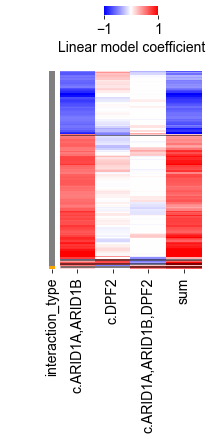

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model

alpha=0.01

my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

modelname='ARIDs_DPF2'
ps=['ARID1A,ARID1B','DPF2','ARID1A,ARID1B,DPF2']
ps2=['c.'+gene for gene in ps]
ps.append('control')
adata_here=adata_small[adata.obs['gene'].isin(ps),:]

perturb.lm.train_lm(adata_here,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname,
        perturbations_list=ps2,#gene_guides_w_combo,
        covariates_list=covariates,
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)


run_permuted_models(adata_here,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

coef_FDR(adata_here,'gene',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])


g1='ARID1A,ARID1B'
g2='DPF2'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_here,
                                                                          modelname,
                                                                          g1,g2)
gos=go_analysis(coef_pattern)
import re
for cat in gos['p_value2'].columns:
    if '000' in cat:
        continue
    print_terms(gos,re.sub('Pro: ','',cat))


Trying to set attribute `.obs` of view, copying.


splitting train    760
test      95
valid     95
Name: train_valid_test, dtype: int64
Found 3/3 perturbations
Found 0/0 obs
Found 5/5 covariates
(950, 3) (950, 5) (950, 1761)
train    760
test      95
valid     95
Name: PS.ARIDs_BRD9.train_valid_test, dtype: int64
train 760
valid 95
test 95

Fitting model
 ElasticNet(alpha=0.01, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FE746F340,
           selection='random')
x (950, 8)
model coeff (1761, 8)
== Permuting data
Running model on permuted data #0
Running model on permuted data #1
Running model on permuted data #2
Running model on permuted data #3
Running model on permuted data #4
Running model on permuted data #5
Running model on permuted data #6
Running model on permuted data #7
Running model on permuted data #8
Running model on permuted data #9
== Computing coefficient significance
fdr SDCBP         0.000319
BTN3A1        0.624354
MAP2K1        0.624354
FBXL5         0.000021
FGD3          0.624354
          

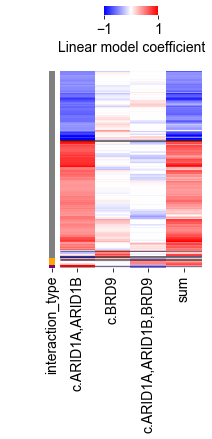

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

modelname='ARIDs_BRD9'
ps=['ARID1A,ARID1B','BRD9','ARID1A,ARID1B,BRD9']
ps2=['c.'+gene for gene in ps]
ps.append('control')
adata_here=adata_small[adata.obs['gene'].isin(ps),:]

perturb.lm.train_lm(adata_here,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname,
        perturbations_list=ps2,#gene_guides_w_combo,
        covariates_list=covariates,
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)


run_permuted_models(adata_here,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

coef_FDR(adata_here,'gene',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])


g1='ARID1A,ARID1B'
g2='BRD9'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_here,
                                                                          modelname,
                                                                          g1,g2)
gos=go_analysis(coef_pattern)
import re
for cat in gos['p_value2'].columns:
    if '000' in cat:
        continue
    print_terms(gos,re.sub('Pro: ','',cat))



Trying to set attribute `.obs` of view, copying.


splitting train    877
test     110
valid    110
Name: train_valid_test, dtype: int64
Found 3/3 perturbations
Found 0/0 obs
Found 5/5 covariates
(1097, 3) (1097, 5) (1097, 1761)
train    877
test     110
valid    110
Name: PS.ARIDs_ARID2.train_valid_test, dtype: int64
train 877
valid 110
test 110

Fitting model
 ElasticNet(alpha=0.01, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FE746FD40,
           selection='random')
x (1097, 8)
model coeff (1761, 8)
== Permuting data
Running model on permuted data #0
Running model on permuted data #1
Running model on permuted data #2
Running model on permuted data #3
Running model on permuted data #4
Running model on permuted data #5
Running model on permuted data #6
Running model on permuted data #7
Running model on permuted data #8
Running model on permuted data #9
== Computing coefficient significance
fdr SDCBP         0.000028
BTN3A1        0.347785
MAP2K1        0.589438
FBXL5         0.000035
FGD3          0.538614
   

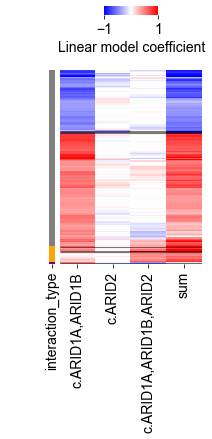

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

modelname='ARIDs_ARID2'
ps=['ARID1A,ARID1B','ARID2','ARID1A,ARID1B,ARID2']
ps2=['c.'+gene for gene in ps]
ps.append('control')
adata_here=adata_small[adata.obs['gene'].isin(ps),:]

perturb.lm.train_lm(adata_here,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname,
        perturbations_list=ps2,#gene_guides_w_combo,
        covariates_list=covariates,
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)


run_permuted_models(adata_here,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

coef_FDR(adata_here,'gene',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])


g1='ARID1A,ARID1B'
g2='ARID2'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_here,
                                                                          modelname,
                                                                          g1,g2)
gos=go_analysis(coef_pattern)


Trying to set attribute `.obs` of view, copying.


splitting train    957
test     120
valid    120
Name: train_valid_test, dtype: int64
Found 3/3 perturbations
Found 0/0 obs
Found 5/5 covariates
(1197, 3) (1197, 5) (1197, 1761)
train    957
test     120
valid    120
Name: PS.ARID2_BRD9.train_valid_test, dtype: int64
train 957
valid 120
test 120

Fitting model
 ElasticNet(alpha=0.01, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FE746FC40,
           selection='random')
x (1197, 8)
model coeff (1761, 8)
== Permuting data
Running model on permuted data #0
Running model on permuted data #1
Running model on permuted data #2
Running model on permuted data #3
Running model on permuted data #4
Running model on permuted data #5
Running model on permuted data #6
Running model on permuted data #7
Running model on permuted data #8
Running model on permuted data #9
== Computing coefficient significance
fdr SDCBP         0.079152
BTN3A1        0.493072
MAP2K1        0.099560
FBXL5         0.057957
FGD3          0.254884
    

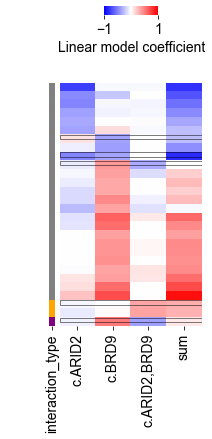

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

modelname='ARID2_BRD9'
ps=['ARID2','BRD9','ARID2,BRD9']
ps2=['c.'+gene for gene in ps]
ps.append('control')
adata_here=adata_small[adata.obs['gene'].isin(ps),:]

perturb.lm.train_lm(adata_here,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname,
        perturbations_list=ps2,#gene_guides_w_combo,
        covariates_list=covariates,
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)


run_permuted_models(adata_here,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

coef_FDR(adata_here,'gene',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])


g1='ARID2'
g2='BRD9'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_here,
                                                                          modelname,
                                                                          g1,g2)
gos=go_analysis(coef_pattern)




In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000,random_state=my_rng,selection='random')

modelname='GLTSCRs'

ps=['GLTSCR1','GLTSCR1L','GLTSCR1,GLTSCR1L']
ps2=['c.'+gene for gene in ps]
ps.append('control')
adata_here=adata_small[adata.obs['gene'].isin(ps),:]

perturb.lm.train_lm(adata_here,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname,
        perturbations_list=ps2,#gene_guides_w_combo,
        covariates_list=covariates,
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)


run_permuted_models(adata_here,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

coef_FDR(adata_here,'gene',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])


g1='GLTSCR1'
g2='GLTSCR1L'
sorted_data,gene_interaction_term,coef_pattern=plot_interaction_term_data(adata_here,
                                                                          modelname,
                                                                          g1,g2)
gos=go_analysis(coef_pattern)

Trying to set attribute `.obs` of view, copying.


splitting train    740
test      93
valid     92
Name: train_valid_test, dtype: int64
Found 3/3 perturbations
Found 0/0 obs
Found 5/5 covariates
(925, 3) (925, 5) (925, 1761)
train    740
test      93
valid     92
Name: PS.GLTSCRs.train_valid_test, dtype: int64
train 740
valid 92
test 93

Fitting model
 ElasticNet(alpha=0.01, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7F9FE746F440,
           selection='random')
x (925, 8)
model coeff (1761, 8)
== Permuting data
Running model on permuted data #0
Running model on permuted data #1
Running model on permuted data #2
Running model on permuted data #3
Running model on permuted data #4
Running model on permuted data #5
Running model on permuted data #6
Running model on permuted data #7
Running model on permuted data #8
Running model on permuted data #9
== Computing coefficient significance
fdr SDCBP         0.122601
BTN3A1        0.583426
MAP2K1        0.342142
FBXL5         0.583426
FGD3          0.143470
             

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 216x432 with 0 Axes>

In [ ]:
perturb.tl.bulk(adata_small,'gene')

In [ ]:
thebulk=adata_small.uns['bulk.gene'].T

In [ ]:
def plot_additive(g1,g2,thebulk):
    thecombo=g1+','+g2

    X=thebulk.loc[:,[g1,g2]]
    y=thebulk[thecombo]

    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import ElasticNet
    from sklearn import linear_model
    my_rng=np.random.RandomState(1234)
    reg=linear_model.ElasticNet(l1_ratio=0,alpha=0.0005,max_iter=10000,random_state=my_rng,selection='random')

    reg.fit(X,y)
    pred=reg.predict(X)
    x=y.abs().max()

    fig,plots=plt.subplots(1)
    fig.set_size_inches(7,5)
    plots.scatter(pred,y,color='black',s=5,alpha=0.25)
    plots.plot([-x,x],[-x,x],color='blue',linestyle='--')
    plots.set_xlabel('Predicted from additive model',fontsize=20)
    plots.set_ylabel('Observed',fontsize=20)
    plots.grid(False)

    plt.savefig(FIGS+'combo.additive'+modelname+g1+'.'+g2+'.scatter.pdf',transparent=True,bbox_inches='tight')
    plt.savefig(FIGS+'combo.additive'+modelname+g1+'.'+g2+'.scatter.png',transparent=True,bbox_inches='tight')


g1='ARID1A'
g2='ARID1B'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='SMARCC1'
g2='SMARCC2'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='ARID1A,ARID1B'
g2='BRD9'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='ARID1A,ARID1B'
g2='ARID2'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='ARID2'
g2='BRD9'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='ARID1A,ARID1B'
g2='DPF2'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='SMARCA2'
g2='SMARCA4'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='SMARCD1'
g2='SMARCD2'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='GLTSCR1'
g2='GLTSCR1L'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='SS18'
g2='SS18L'
plot_additive(g1,g2,thebulk)

In [ ]:
g1='DPF2'
g2='PHF10'
plot_additive(g1,g2,thebulk)

In [ ]:
adata.obs['gene'].value_counts()

In [ ]:
badata=sc.AnnData(thebulk.T)
badata

In [ ]:
sc.tl.pca(badata)

In [ ]:
sc.pp.neighbors(badata)

In [ ]:
sc.tl.umap(badata)

In [ ]:
sc.pl.umap(badata)

In [ ]:
g1s=['ARID1A','SMARCC1','SMARCD1','GLTSCR1','SMARCA2','DPF2','SS18','ARID1A,ARID1B','ARID1A,ARID1B']
g2s=['ARID1B','SMARCC2','SMARCD2','GLTSCR1L','SMARCA4','PHF10','SS18L','BRD9','ARID2']

names=[]
scores=[]
domscores=[]
for i in range(len(g1s)):
    g1=g1s[i]
    g2=g2s[i]
    
    thecombo=g1+','+g2

    X=thebulk.loc[:,[g1,g2]]
    y=thebulk[thecombo]

    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import ElasticNet
    from sklearn import linear_model
    my_rng=np.random.RandomState(1234)
    reg=linear_model.ElasticNet(l1_ratio=0,alpha=0.0005,max_iter=10000,random_state=my_rng,selection='random')

    reg.fit(X,y)
    pred=reg.predict(X)
    x=y.abs().max()
    plt.scatter(pred,y,s=5,alpha=0.25,color='black')
    plt.plot([-x,x],[-x,x],color='blue',linestyle='--')
    plt.xlabel('Additive')
    plt.ylabel('Observed')
    plt.title(g1+' '+g2)
    plt.grid(False)
    plt.show()
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    sc=r2_score(pred,y)
    names.append(g1+' | '+g2)
    scores.append(sc)
    
    #dominance
    c1,c2=reg.coef_[0],reg.coef_[1]
    c1=np.abs(c1)
    c2=np.abs(c2)
    domsc=np.log10(np.max([c1,c2])/np.min([c1,c2]))
    domscores.append(domsc)
    
scoremat=pd.DataFrame({'name':names,'score':scores,'dom':domscores})
    

In [ ]:
scoremat=scoremat.sort_values(by='score')


fig,plots=plt.subplots(1)
fig.set_size_inches(3,3)
plots.barh(scoremat['name'],scoremat['score'],color='black',)
plots.grid(False)
plots.set_xlabel('Additivity score')
plots.set_ylabel('Pertubation combination')
#plots.set_xlim(0,1)

plt.savefig(FIGS+'combo.additivityScoreParalogs.bar.pdf',transparent=True,bbox_inches='tight')
plt.savefig(FIGS+'combo.additivityScoreParalogs.bar.png',transparent=True,bbox_inches='tight')


In [ ]:
fig,plots=plt.subplots(1)

plots.scatter(scoremat['dom'],scoremat['score'],color='black')
plots.set_xlabel('dominance')
plots.set_ylabel('additivity')
scoremat.index=list(scoremat['name'])
for i, txt in enumerate(list(scoremat['name'])):
    print(txt, (scoremat['dom'][i], scoremat['score'][i]))
    plots.annotate(txt, (scoremat.loc[txt,'dom'], scoremat.loc[txt,'score']))
plots.grid(False)

In [ ]:
scoremat

In [ ]:
x=1
sns.clustermap(thebulk.loc[:,['BRD9','GLTSCR1','GLTSCR1L','GLTSCR1,GLTSCR1L','BRD9,GLTSCR1,GLTSCR1L']],
               figsize=(5,10),col_cluster=False,
              cmap='bwr',vmin=-x,vmax=x)

In [ ]:
corrmat=perturb.util.corr_mat(thebulk.T)

In [ ]:
items=corrmat.columns

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage



var_Z = hierarchy.linkage(corrmat.loc[items,items],
                                 optimal_ordering=True,
                                  #metric='cityblock',
                                         method='median')

x=1
sns.clustermap(corrmat.loc[items,items],
               vmin=-x,vmax=x,
               row_linkage=var_Z,col_linkage=var_Z,
               xticklabels=True,
               yticklabels=True,
               cmap='bwr',
               figsize=(20,20),
               cbar_pos=(0.35, 0.95, 0.1, 0.03),
                     cbar_kws={'orientation':'horizontal',
                    "label": "Spearman\ncorrelation",
                    'ticks':[-x,x]},
              )

plt.savefig(FIGS+'combo.bulkcorr.heatmap.pdf',transparent=True,bbox_inches='tight')
plt.savefig(FIGS+'combo.bulkcorr.heatmap.png',transparent=True,bbox_inches='tight')

In [ ]:
items=['BRD9','GLTSCR1','GLTSCR1L','GLTSCR1,GLTSCR1L','BRD9,GLTSCR1,GLTSCR1L']


var_Z = hierarchy.linkage(corrmat.loc[items,items],
                                 optimal_ordering=True,
                                  #metric='cityblock',
                                         method='median')

sns.clustermap(corrmat.loc[items,items],
               vmin=-x,vmax=x,
               row_linkage=var_Z,col_linkage=var_Z,
               cmap='bwr',
               figsize=(5,5),
               cbar_pos=(0.15, 1.1, 0.25, 0.05),
                     cbar_kws={'orientation':'horizontal',
                    "label": "Spearman correlation",
                    'ticks':[-x,x]},
               
              )

plt.savefig(FIGS+'combo.GLTSCRs.bulkcorr.heatmap.pdf',transparent=True,bbox_inches='tight')
plt.savefig(FIGS+'combo.GLTSCRs.bulkcorr.heatmap.png',transparent=True,bbox_inches='tight')


In [ ]:
#expression of the targeted gene
genes=set(adata.obs['gene.compact'])
print(genes)
print(len(genes))

In [ ]:
#sort by average expression of the genes
perturb.tl.bulk(adata,'gene.compact',use_raw=True,return_matrix=True)
genes_only=list(set(genes).difference(set(['control','unassigned','multiple'])))
gene_avg=pd.DataFrame({'gene':genes_only,'expr':0,
                       },
                     index=genes_only)

for gene in genes_only:
    if gene in adata.var_names:
        gene_avg.loc[gene,'expr']=adata.uns['bulk.gene.compact'].loc['control',gene]

gene_avg=gene_avg.sort_values(by='expr')
print(gene_avg.shape)
del adata.uns['bulk.gene.compact']
gene_avg.head()

In [ ]:
adata.uns['target_gene_expr_in_control']=gene_avg

In [ ]:
import copy

guides=list(set(adata.obs['guide.compact']).difference(set(['multiple','unassigned'])))
guide2gene=adata.uns['guide2gene']

ntcs=['NTC1_IG345439','NTC2_IG216151','NTC5_mNTC100A67005','NTC6_IG1216445','NTC7_IG1144056']
rest=list(gene_avg.index)

#get the order of the guides
guides.sort()
ordered_guides=copy.deepcopy(ntcs)
for gene in rest:
    for g in list(guides):
        if gene==guide2gene.loc[g,'gene']:
            ordered_guides.append(g)
    
print(ordered_guides)
print(len(ordered_guides))

In [ ]:
genes=[]
for i in range(len(rest)):
    genes.append(rest[i])
print(genes)
print(len(genes))

In [ ]:
import copy
df=copy.deepcopy(adata.obs['guide.compact']).astype(str)
df.loc[adata.obs['gene.compact']=='control']='control'
print(df)

adata.obs['guide.compact.with_control']=df

In [ ]:
adata.uns['sorted_guides']=ordered_guides
adata.uns['sorted_genes']=genes

In [ ]:
fig,plots=plt.subplots(1)
fig.set_size_inches(10,3)
vmin=-1
vmax=1

#expression level of genes
sorted_genes=adata.uns['sorted_genes']
plots.bar([x for x in range(len(sorted_genes))],
       list(adata.uns['target_gene_expr_in_control'].loc[sorted_genes,'expr']),color='black')
plots.grid(False)
#ax_top.set_xticks([])
plots.spines['right'].set_visible(False)
plots.spines['left'].set_visible(True)
plots.spines['top'].set_visible(False)
plots.spines['bottom'].set_visible(True)
plots.set_xticks(range(len(sorted_genes)))
plots.set_xticklabels(sorted_genes,fontsize=15,rotation=270)
plots.xaxis.set_ticks_position('bottom')
plots.set_ylabel('Expression of\ntargeted gene',fontsize=20)
plots.set_xlim(-0.5,len(sorted_genes)-0.5)

plt.savefig(FIGS+'combo.targeted_gene_expr_in_ctrl.bar.pdf',transparent=True,bbox_inches='tight')
plt.savefig(FIGS+'combo.targeted_gene_expr_in_ctrl.bar.png',transparent=True,bbox_inches='tight')


In [ ]:
x=perturb.pp.gene_mean_with_sig(adata,
                    gene_list=genes,
                    ref='control',
                   grouping_variable='gene.compact')

In [ ]:
perturb.pl.dotplot2(x[0],x[1],genes[::-1],genes[::1],w=10,h=8,best_p=1e-10,
        title='Average expression\n(relative to control)')

plt.savefig(FIGS+'combo.gene.ko.dotplot.pdf',transparent=True)
plt.savefig(FIGS+'combo.gene.ko.dotplot.png',transparent=True)

In [ ]:
x=perturb.pp.gene_mean_with_sig(adata,
                    gene_list=genes,
                    ref='control',
                   grouping_variable='guide.compact.with_control')

In [ ]:
perturb.pl.dotplot2(x[0],x[1],genes[::-1],ordered_guides[5:],w=10,h=25,best_p=1e-10,
        title='Average expression\n(relative to control)')
plt.savefig(FIGS+'combo.guide.ko.dotplot.pdf',transparent=True)
plt.savefig(FIGS+'combo.guide.ko.dotplot.png',transparent=True)

In [ ]:
expr_effects=pd.DataFrame(columns=['value','condition','perturbation'])

for g in genes:       
    
    control_cells=adata.obs_names[adata.obs['control']>0]
    gcells=adata.obs_names[adata.obs[g].astype(float)>0]

    if g in adata.var_names:
        control_values=list(adata.raw[control_cells,g].X.toarray().flatten())
        g_values=list(adata.raw[gcells,g].X.toarray().flatten())
    else:
        control_values=[np.nan]
        g_values=[np.nan]
        
    expr_effects_control=pd.DataFrame({'value':control_values,
                                    'condition':'control',
                                    'perturbation':g,
                                   })
    expr_effects_g=pd.DataFrame({'value':g_values,
                                    'condition':'perturbation',
                                    'perturbation':g,
                                   })
        
    expr_effects=pd.concat([expr_effects,expr_effects_control,expr_effects_g],axis=0)

expr_effects.head()

In [ ]:
import seaborn as sns
from statannot import add_stat_annotation



fig, ax = plt.subplots(figsize=(20,5))

sns.boxplot(data=expr_effects, x="perturbation", y="value", 
               hue="condition",
            linewidth=1,
               ax=ax,width=0.65,
               palette={'control':'lightgray','perturbation':'lightblue'},
               #palette={"Yes": "b", "No": ".85"},
              )

ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right',fontsize=20)

box_pairs=[]
for gene in genes:
    if gene not in adata.var_names:
        continue
    box_pairs.append(((gene,'control'),(gene,'perturbation')))

    
add_stat_annotation(ax, data=expr_effects, x="perturbation", y="value", 
               hue="condition",
                    box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)

plt.grid(False)

plt.savefig(FIGS+'combo.geneKOtarget.box.pdf',transparent=True,bbox_inches='tight')
plt.savefig(FIGS+'combo.geneKOtarget.box.png',transparent=True,bbox_inches='tight')

In [ ]:
?perturb.pp.perturbs_per_cell 
#(adata)

In [ ]:
adata

In [ ]:
desired_combos=['ARID1A_3,ARID1B_4',
 'ARID1A_3,ARID1B_4,ARID2_1',
 'ARID1A_3,ARID1B_4,BRD9_2',
 'ARID1A_3,ARID1B_4,DPF2_4',
 'ARID1A_3,ARID1B_4,SMARCB1_5',
 'ARID1A_3,ARID1B_4,SMARCE1_1',
 
 'ARID2_1,BRD9_2',
 'ARID2_1,SMARCB1_5',
 'ARID2_1,SMARCE1_1',
 #'BCL7A_3,BCL7B_1',
 #'BCL7A_3,BCL7C_2',
 #'BCL7B_1,BCL7C_2',
#'ARID2_1,BRD7_2,PBRM1_3',
 'BRD9_2,GLTSCR1L_3,GLTSCR1_1',
 'DPF2_4,PHF10_1',
 'GLTSCR1L_3,GLTSCR1_1',
 'NTC1_IG345439',
 'NTC1_IG345439,NTC6_IG1216445',
 'NTC1_IG345439,NTC6_IG1216445,NTC7_IG1144056',
 'SMARCA2_4,SMARCA4_4',
 'SMARCC1_7,SMARCC2_3',
 'SMARCD1_4,SMARCD2_3',
 'SS18L_1,SS18_2']

In [ ]:
hist_values=adata.obs['guide'].value_counts().loc[desired_combos]
plt.hist(hist_values)

In [ ]:
hist_values.index

In [ ]:
hist_values.sort_values()